In [5]:

from scipy.special import legendre
from scipy import special
import os

from mp_movement_classifier.utils import config
from mp_movement_classifier.utils.utils import (
    load_model_with_full_state,
    process_exp_map_data,
    process_bvh_data,
    read_bvh_files,
    save_model_with_full_state,

)

In [3]:



def shifted_legendre_polynomial(degree, r):
    """
    Compute shifted Legendre polynomial of specified degree at point r.
    
    Parameters:
    - degree: int, degree of the polynomial
    - r: float or array, points where to evaluate the polynomial in range [0, 1]
    
    Returns:
    - values of the shifted Legendre polynomial at r
    """
    x = 2 * r - 1  # Map from [0, 1] to [-1, 1]
    return special.eval_legendre(degree, x)

def generate_legendre_basis(max_degree, time_points):
    """
    Generate basis of Legendre polynomials up to max_degree.
    
    Parameters:
    - max_degree: int, maximum degree of polynomials
    - time_points: array, normalized time points in [0, 1]
    
    Returns:
    - basis: array of shape (len(time_points), max_degree + 1)
    """
    basis = np.zeros((len(time_points), max_degree + 1))
    for i in range(max_degree + 1):
        basis[:, i] = shifted_legendre_polynomial(i, time_points)
    return basis

def fit_legendre_polynomials(data, max_degree):
    """
    Fit Legendre polynomials to movement data.
    
    Parameters:
    - data: list of arrays, where each array has shape [joints, time]
    - max_degree: int, maximum degree of Legendre polynomials to use
    
    Returns:
    - coefficients: list of arrays, each with shape [joints, max_degree + 1]
    """
    coefficients = []
    
    for segment in data:
        joints, time_steps = segment.shape
        
        # Normalize time to [0, 1]
        time_normalized = np.linspace(0, 1, time_steps)
        
        # Generate Legendre basis
        basis = generate_legendre_basis(max_degree, time_normalized)
        
        # Solve for coefficients using least squares
        segment_coeffs = np.zeros((joints, max_degree + 1))
        for j in range(joints):
            segment_coeffs[j] = np.linalg.lstsq(basis, segment[j], rcond=None)[0]
        
        coefficients.append(segment_coeffs)
    
    return coefficients

def reconstruct_from_coefficients(coefficients, time_steps, max_degree):
    """
    Reconstruct movement data from Legendre coefficients.
    
    Parameters:
    - coefficients: array of shape [joints, max_degree + 1]
    - time_steps: int, number of time steps for reconstruction
    - max_degree: int, maximum degree of Legendre polynomials used
    
    Returns:
    - reconstructed: array of shape [joints, time_steps]
    """
    joints = coefficients.shape[0]
    
    # Normalize time to [0, 1]
    time_normalized = np.linspace(0, 1, time_steps)
    
    # Generate Legendre basis
    basis = generate_legendre_basis(max_degree, time_normalized)
    
    # Reconstruct
    reconstructed = np.zeros((joints, time_steps))
    for j in range(joints):
        reconstructed[j] = np.dot(basis, coefficients[j])
    
    return reconstructed

In [4]:
def process_with_legendre_basis(processed_data, max_degree):
    """
    Process all movement segments using Legendre polynomial basis.
    
    Parameters:
    - processed_data: list of arrays, each with shape [joints, time]
    - max_degree: int, maximum degree of Legendre polynomials to use
    
    Returns:
    - coefficients: list of arrays, each with shape [joints, max_degree + 1]
    - reconstruction_error: list of errors for each segment
    """
    coefficients = fit_legendre_polynomials(processed_data, max_degree)
    
    # Calculate reconstruction error for each segment
    reconstruction_error = []
    for i, segment in enumerate(processed_data):
        joints, time_steps = segment.shape
        reconstructed = reconstruct_from_coefficients(coefficients[i], time_steps, max_degree)
        error = np.mean((segment - reconstructed) ** 2)
        reconstruction_error.append(error)
    
    return coefficients, reconstruction_error



In [20]:
num_MPs =5
model_dir = os.path.join("../results/tmp_configs", f"position_mp_model_{num_MPs}")
model_path = os.path.join(model_dir, f"mp_model_{num_MPs}_PC_tpoints_30")
out_dir = os.path.join(model_dir, "legandre_analysis")
out_dir = Path(out_dir)
out_dir.mkdir(parents=True, exist_ok=True)
folder_path = "../data/position_csv_files"
motion_ids, processed_segments, segment_motion_ids = process_exp_map_data(folder_path=folder_path)
num_segments = len(processed_segments)
num_signals = processed_segments[0].shape[0]



Processing ../data/position_csv_files/subject_70_motion_08.csv with motion ID 8
now using position data instead of exp map
now using position data instead of exp map
now using position data instead of exp map
now using position data instead of exp map
Minimum distance in frames: 30
   ✅ Found 4 motion segments
Processing ../data/position_csv_files/subject_59_motion_18.csv with motion ID 18
now using position data instead of exp map
now using position data instead of exp map
now using position data instead of exp map
now using position data instead of exp map
Minimum distance in frames: 30
   ✅ Found 12 motion segments
Processing ../data/position_csv_files/subject_64_motion_19.csv with motion ID 19
now using position data instead of exp map
now using position data instead of exp map
now using position data instead of exp map
now using position data instead of exp map
Minimum distance in frames: 30
   ✅ Found 4 motion segments
Processing ../data/position_csv_files/subject_70_motion_20.cs

In [21]:
import numpy as np
max_degree = 5  # For 10 degrees (0 to 9)
coefficients, errors = process_with_legendre_basis(processed_segments, max_degree)



In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def prepare_coefficient_data(coefficients, motion_ids):
    
    X = np.array([coef.flatten() for coef in coefficients])
    y = np.array(motion_ids)
    
    return X, y

def visualize_with_pca(X, y,out_dir):

    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.8)
    
    plt.colorbar(scatter, label='Motion Type')
    
    plt.xlabel(f'PC1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2f})')
    plt.ylabel(f'PC2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2f})')
    plt.title('PCA of Legendre Polynomial Coefficients')
    
    unique_motions = np.unique(y)
    handles = [plt.Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=plt.cm.viridis(i / len(unique_motions)), 
                          markersize=10) for i in range(len(unique_motions))]
    plt.legend(handles, unique_motions, title='Motion Types')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    out_path = Path(out_dir) / 'pca_visualization.png'
    plt.savefig(out_path, dpi=150)

    plt.show()
    
    return pca

def visualize_with_tsne(X, y,out_dir):
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X)-1))
    X_tsne = tsne.fit_transform(X)
    
    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.8)
    
    # Add a colorbar
    plt.colorbar(scatter, label='Motion Type')
    
    # Add labels and title
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('t-SNE of Legendre Polynomial Coefficients')
    
    # Add legend for unique motion types
    unique_motions = np.unique(y)
    handles = [plt.Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=plt.cm.viridis(i / len(unique_motions)), 
                          markersize=10) for i in range(len(unique_motions))]
    plt.legend(handles, unique_motions, title='Motion Types')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    out_path = Path(out_dir) / 'tsne_visualization.png'
    plt.savefig(out_path, dpi=150)
    plt.show()
    
    return tsne

def classify_motion_types(X, y,out_dir):
   
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y if len(np.unique(y)) > 1 else None
    )
    
    # Train a Random Forest classifier
    classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    classifier.fit(X_train, y_train)
    
    # Make predictions
    y_pred = classifier.predict(X_test)
    
    # Evaluate the classifier
    accuracy = np.mean(y_pred == y_test)
    print(f"Classification Accuracy: {accuracy:.4f}")
    report = classification_report(y_test, y_pred)
    path = os.path.join(out_dir, "classification_report.txt")
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        f.write(report)

    
    # Create confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    out_path = Path(out_dir) / 'confusion_matrix.png'
    plt.savefig(out_path, dpi=150)
    plt.show()
    
    return classifier, accuracy

def visualize_feature_importance(classifier, X, y,out_dir):
    
    if hasattr(classifier, 'feature_importances_'):
        # Get feature importances
        importances = classifier.feature_importances_
        
        # Number of joints and coefficients per joint
        n_joints = X.shape[1] // 10  # Assuming 10 coefficients per joint
        n_coeffs = 10
        
        # Reshape importances to visualize by joint and coefficient
        imp_reshaped = importances.reshape(n_joints, n_coeffs)
        
        # Create a heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(imp_reshaped, cmap='viridis', annot=False)
        plt.xlabel('Legendre Coefficient Index')
        plt.ylabel('Joint Index')
        plt.title('Feature Importance by Joint and Coefficient')
        plt.tight_layout()
        out_path = Path(out_dir) / 'feature_importance.png'
        plt.savefig(out_path, dpi=150)
        plt.show()
        
        # Plot top 20 most important features
        indices = np.argsort(importances)[-20:]
        plt.figure(figsize=(10, 8))
        plt.barh(range(20), importances[indices])
        plt.yticks(range(20), [f"Joint {i // n_coeffs}, Coeff {i % n_coeffs}" for i in indices])
        plt.xlabel('Feature Importance')
        plt.title('Top 20 Most Important Features')
        plt.tight_layout()
        out_path = Path(out_dir) / 'top_features.png'
        plt.savefig(out_path, dpi=150)
        plt.show()


Data shape: (6547, 306), with 20 unique motion types


/Users/arefehfarahmandi/PycharmProjects/Movement_Recognition/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/arefehfarahmandi/PycharmProjects/Movement_Recognition/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/arefehfarahmandi/PycharmProjects/Movement_Recognition/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/arefehfarahmandi/PycharmProjects/Movement_Recognition/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/arefehfarahmandi/PycharmProjects/Movement_Recognition/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_tran

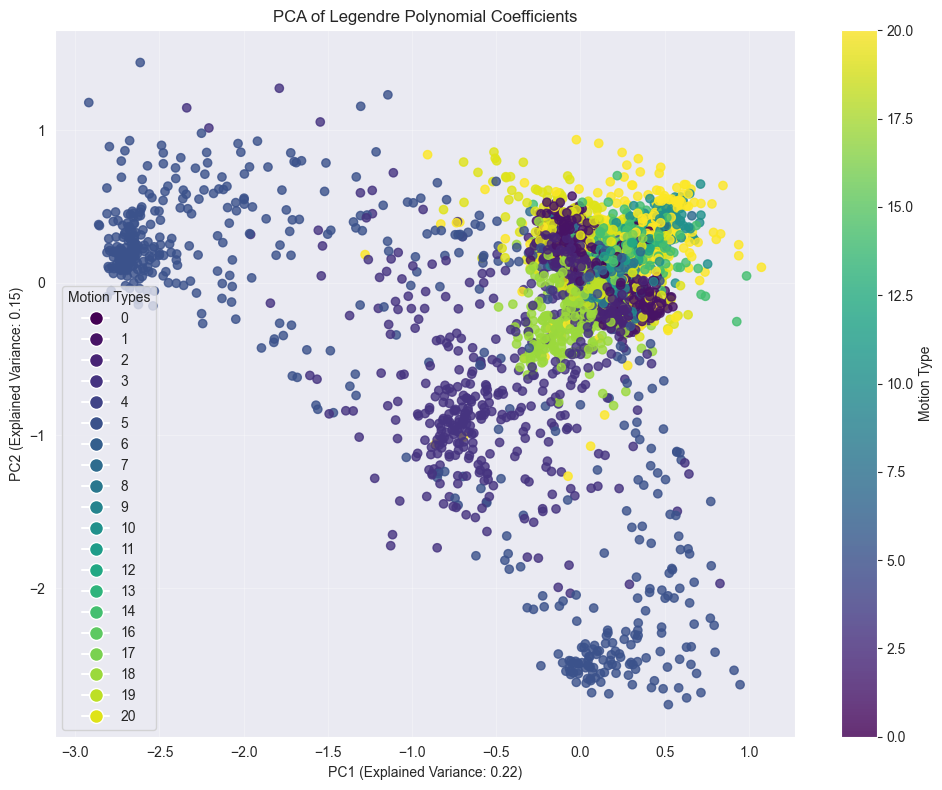

Total variance explained by 2 PCs: 0.3727


/Users/arefehfarahmandi/PycharmProjects/Movement_Recognition/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/arefehfarahmandi/PycharmProjects/Movement_Recognition/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/arefehfarahmandi/PycharmProjects/Movement_Recognition/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/arefehfarahmandi/PycharmProjects/Movement_Recognition/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/arefehfarahmandi/PycharmProjects/Movement_Recognition/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ =

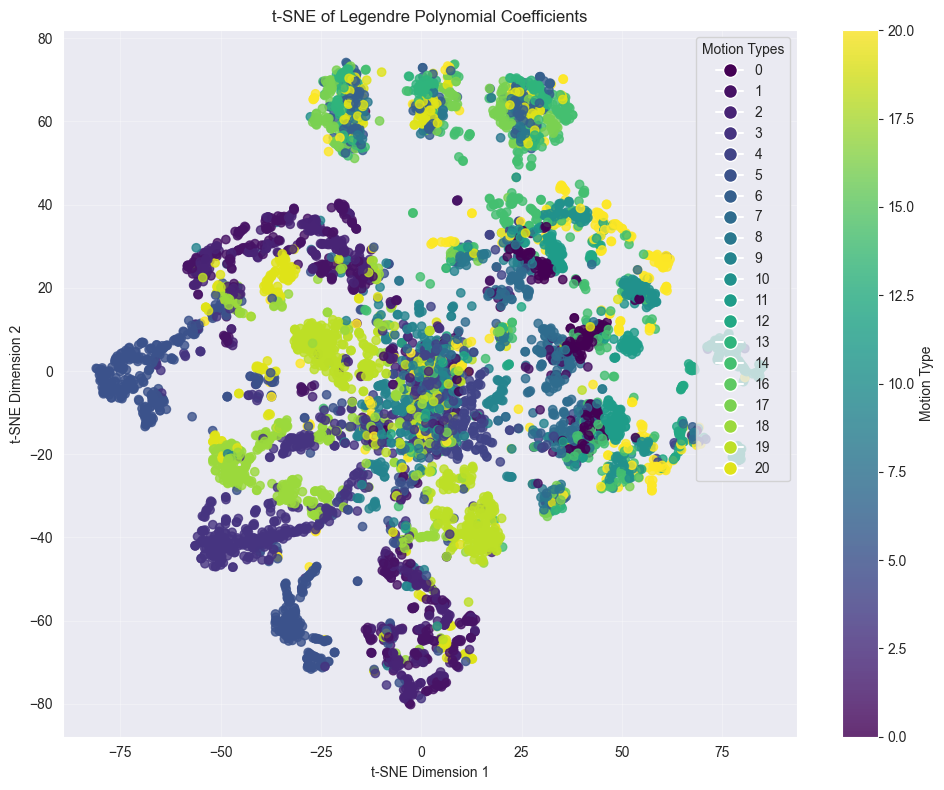

Classification Accuracy: 0.7562


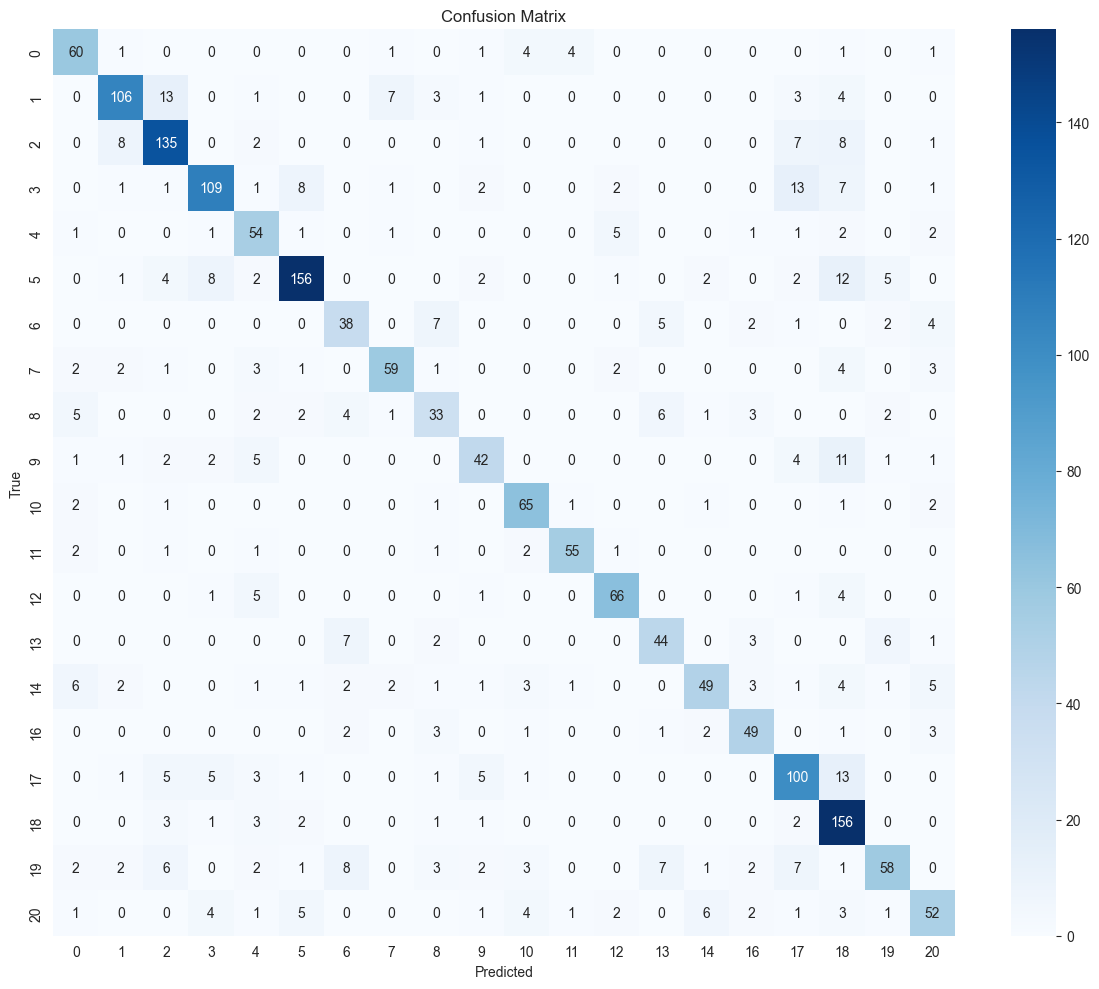

In [25]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from pathlib import Path
import seaborn as sns
X, y = prepare_coefficient_data(coefficients, segment_motion_ids)
print(f"Data shape: {X.shape}, with {len(np.unique(y))} unique motion types")

pca = visualize_with_pca(X, y,out_dir)
print(f"Total variance explained by 2 PCs: {sum(pca.explained_variance_ratio_[:2]):.4f}")

tsne = visualize_with_tsne(X, y,out_dir)

# Classify motion types
classifier, accuracy = classify_motion_types(X, y,out_dir)

Data shape: (410, 594), with 10 unique motion types


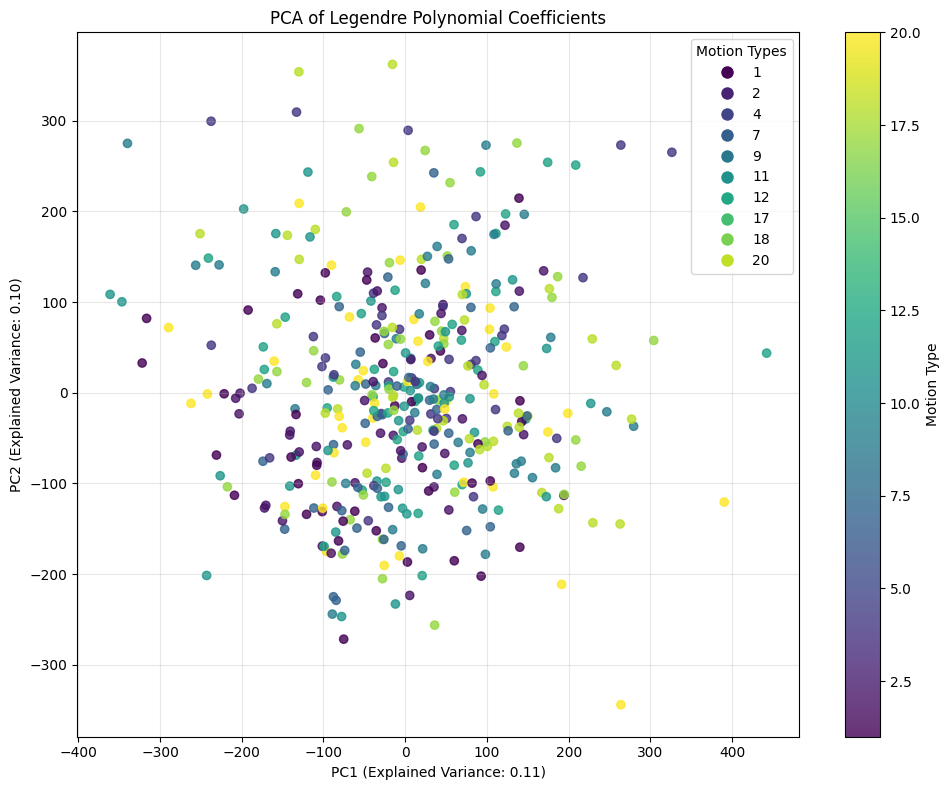

Total variance explained by 2 PCs: 0.2116


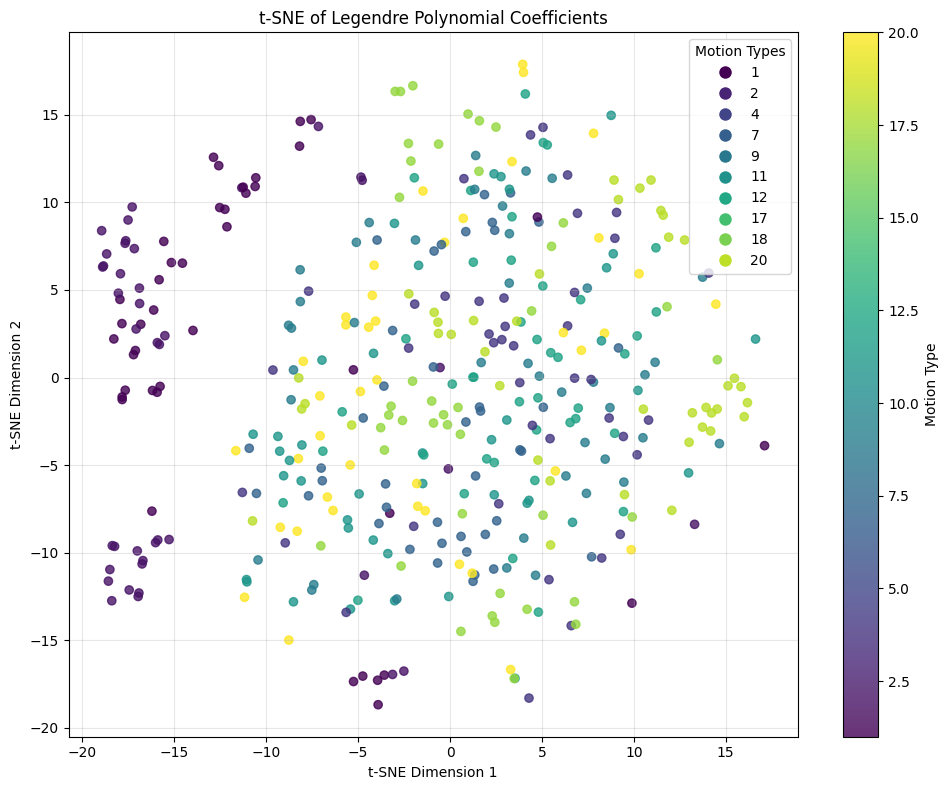

Classification Accuracy: 0.6585

Classification Report:
              precision    recall  f1-score   support

           1       0.82      0.75      0.78        12
           2       0.73      0.92      0.81        12
           4       0.43      0.75      0.55        12
           7       0.65      0.85      0.73        13
           9       0.40      0.15      0.22        13
          11       0.64      0.58      0.61        12
          12       1.00      0.77      0.87        13
          17       0.85      0.92      0.88        12
          18       0.67      0.50      0.57        12
          20       0.45      0.42      0.43        12

    accuracy                           0.66       123
   macro avg       0.66      0.66      0.65       123
weighted avg       0.66      0.66      0.65       123



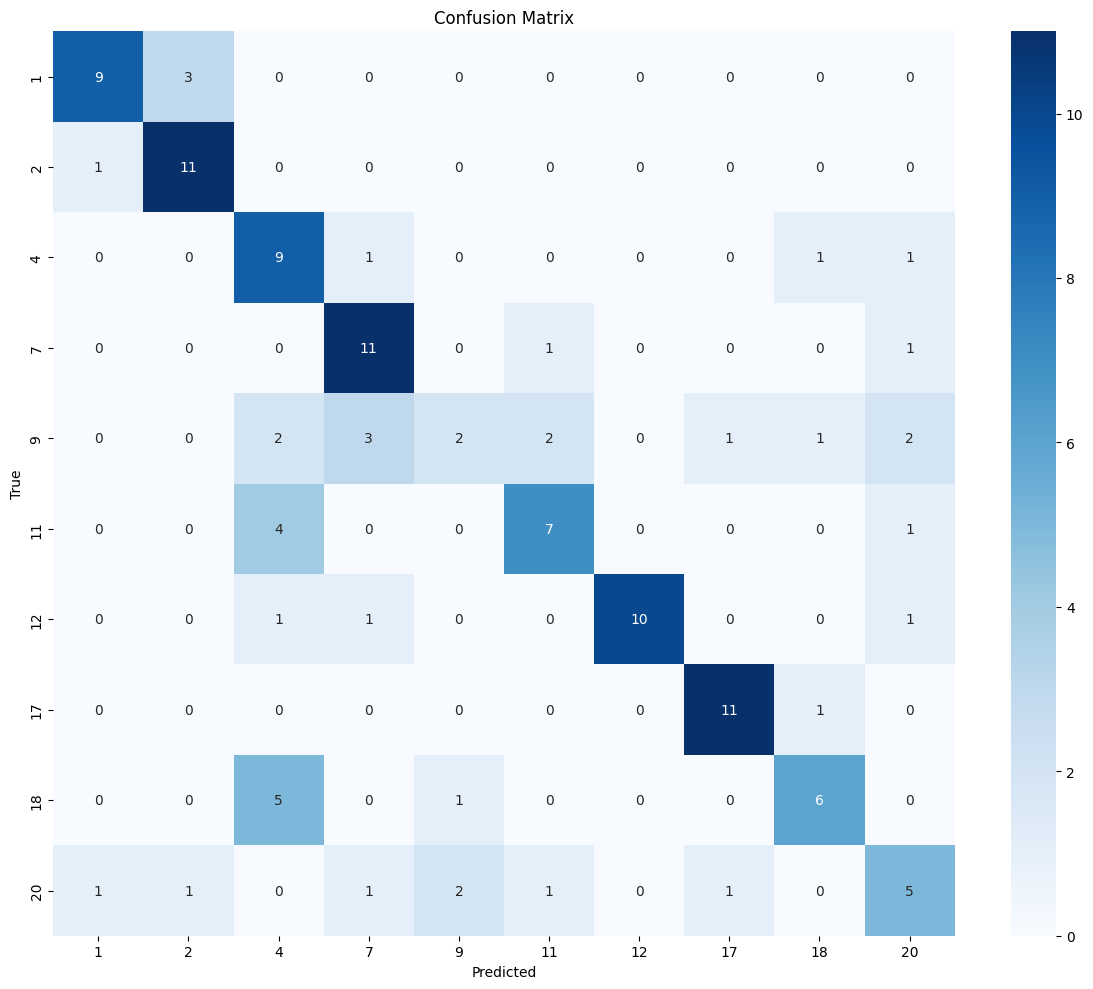

In [8]:
# Main execution
X, y = prepare_coefficient_data(coefficients, filtered_motion_ids)
print(f"Data shape: {X.shape}, with {len(np.unique(y))} unique motion types")

pca = visualize_with_pca(X, y)
print(f"Total variance explained by 2 PCs: {sum(pca.explained_variance_ratio_[:2]):.4f}")

tsne = visualize_with_tsne(X, y)

# Classify motion types
classifier, accuracy = classify_motion_types(X, y)

Data shape: (6197, 1080), with 20 unique motion types


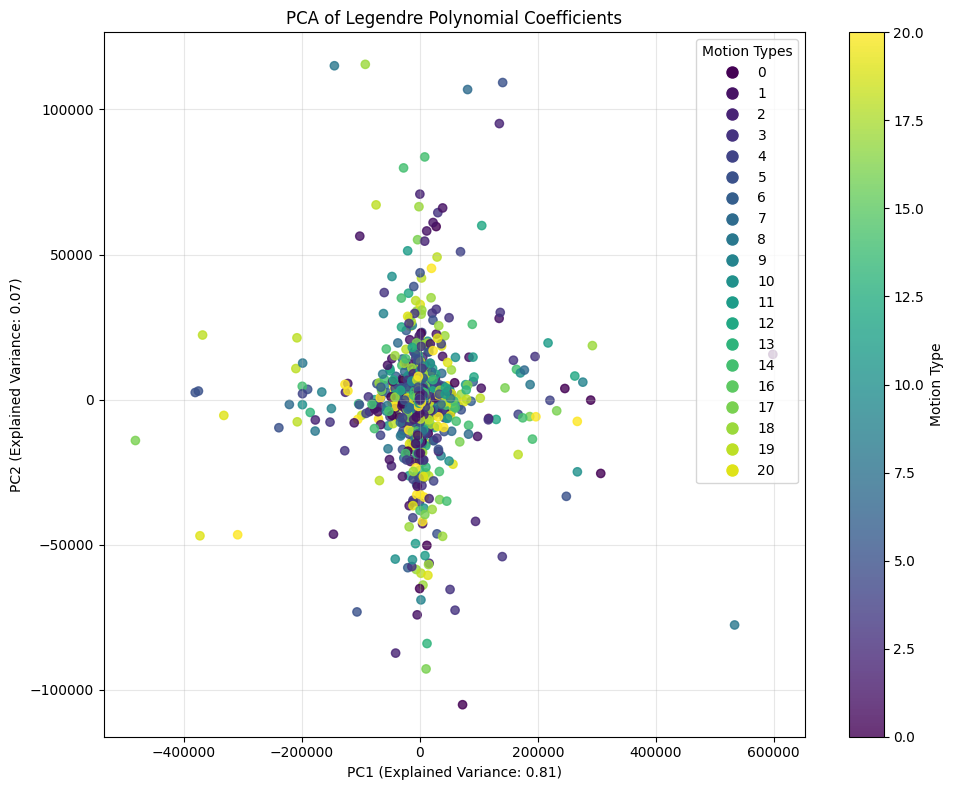

Total variance explained by 2 PCs: 0.8785


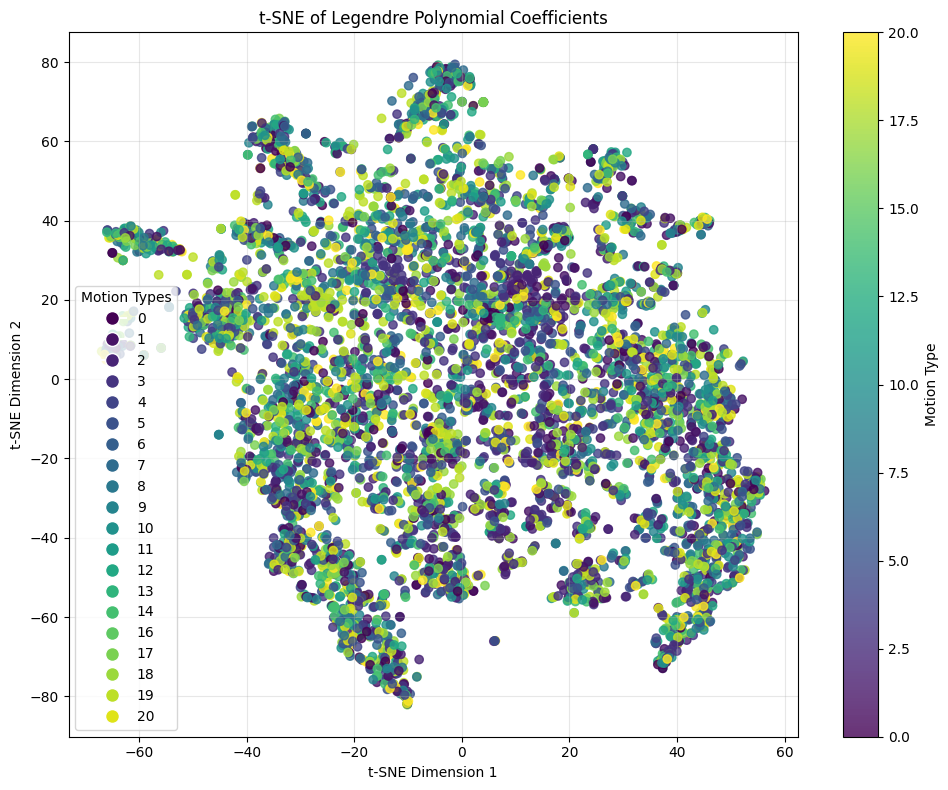

Classification Accuracy: 0.2575

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.29      0.26        73
           1       0.30      0.41      0.35       143
           2       0.29      0.26      0.27        98
           3       0.38      0.44      0.41       155
           4       0.07      0.08      0.08        72
           5       0.52      0.57      0.54       115
           6       0.10      0.13      0.12        67
           7       0.22      0.20      0.21        84
           8       0.13      0.09      0.11        64
           9       0.06      0.03      0.04        75
          10       0.25      0.19      0.21        74
          11       0.11      0.09      0.10        74
          12       0.28      0.27      0.28        77
          13       0.19      0.18      0.19        71
          14       0.18      0.09      0.12        90
          16       0.06      0.03      0.04        67
          17       0.27  

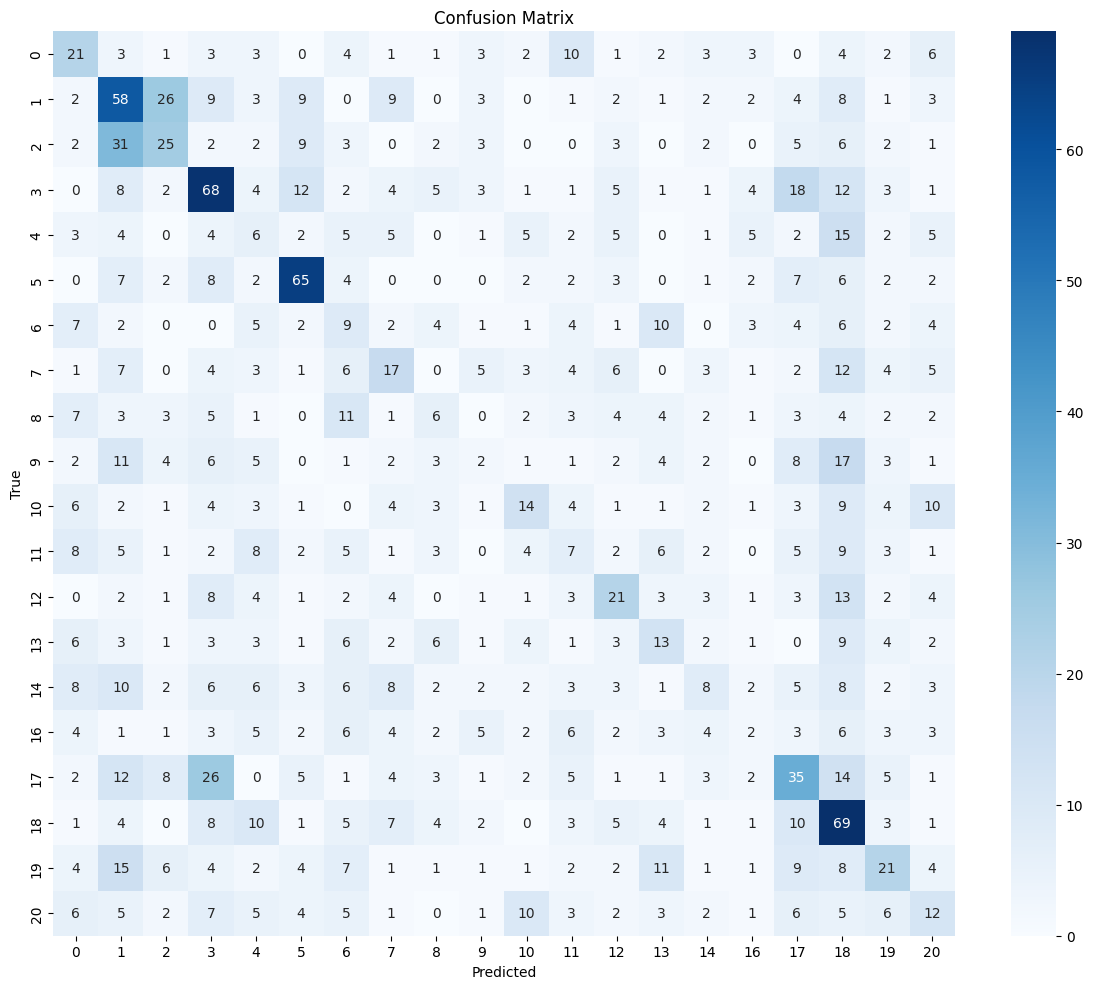

In [12]:
# Main execution
X, y = prepare_coefficient_data(coefficients, motion_ids)
print(f"Data shape: {X.shape}, with {len(np.unique(y))} unique motion types")

pca = visualize_with_pca(X, y)
print(f"Total variance explained by 2 PCs: {sum(pca.explained_variance_ratio_[:2]):.4f}")

tsne = visualize_with_tsne(X, y)

# Classify motion types
classifier, accuracy = classify_motion_types(X, y)

Data shape: (6197, 540), with 20 unique motion types


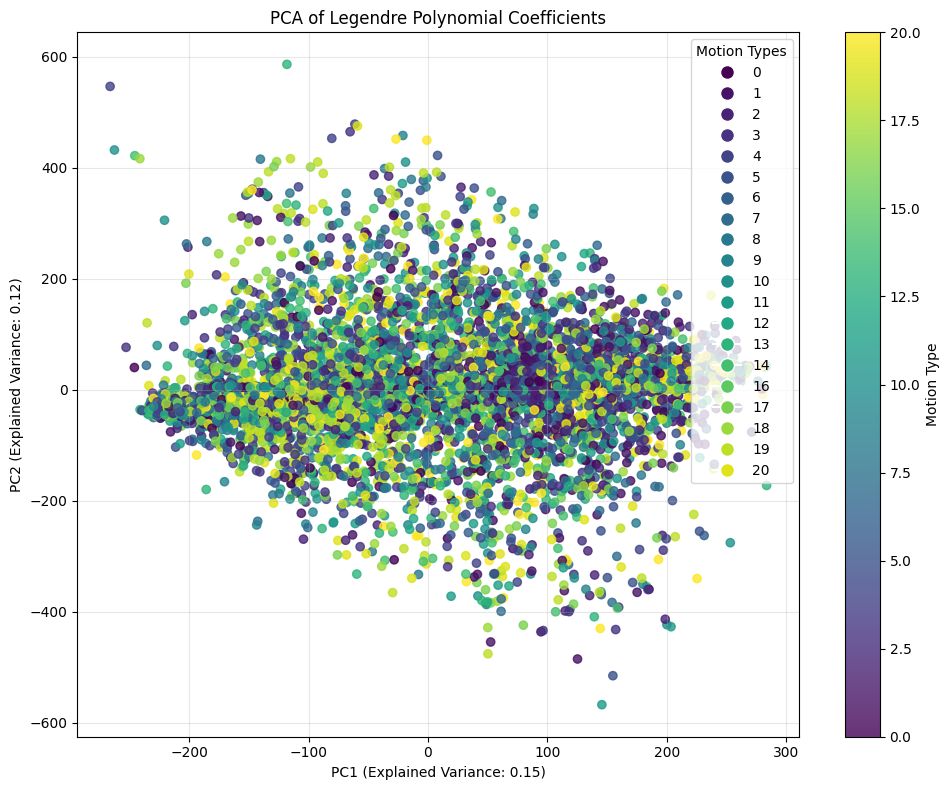

Total variance explained by 2 PCs: 0.2704


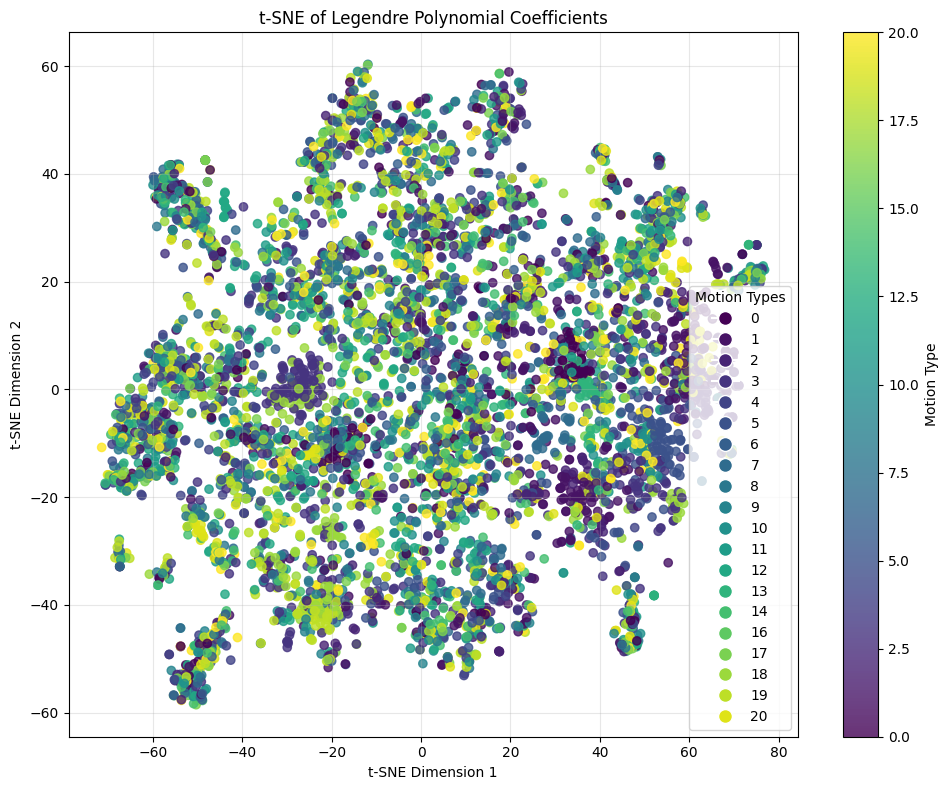

Classification Accuracy: 0.3624

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.45      0.40        73
           1       0.43      0.57      0.49       143
           2       0.55      0.44      0.49        98
           3       0.54      0.44      0.48       155
           4       0.15      0.19      0.17        72
           5       0.72      0.60      0.65       115
           6       0.17      0.25      0.20        67
           7       0.46      0.46      0.46        84
           8       0.30      0.25      0.27        64
           9       0.06      0.03      0.04        75
          10       0.32      0.26      0.29        74
          11       0.29      0.35      0.32        74
          12       0.35      0.34      0.34        77
          13       0.32      0.35      0.33        71
          14       0.26      0.14      0.19        90
          16       0.21      0.10      0.14        67
          17       0.40  

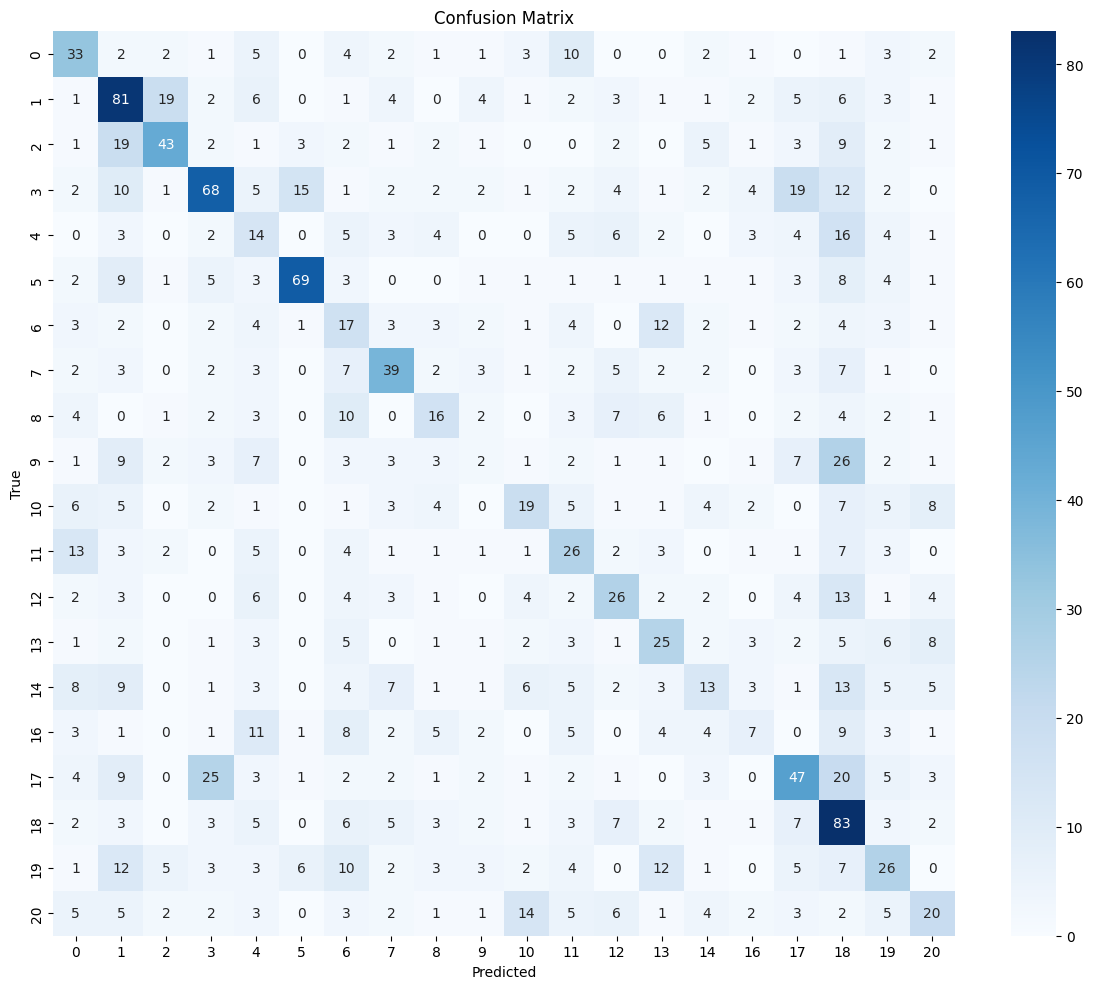

In [ ]:

# Main execution
X, y = prepare_coefficient_data(coefficients, motion_ids)
print(f"Data shape: {X.shape}, with {len(np.unique(y))} unique motion types")

pca = visualize_with_pca(X, y)
print(f"Total variance explained by 2 PCs: {sum(pca.explained_variance_ratio_[:2]):.4f}")

tsne = visualize_with_tsne(X, y)

# Classify motion types
classifier, accuracy = classify_motion_types(X, y)


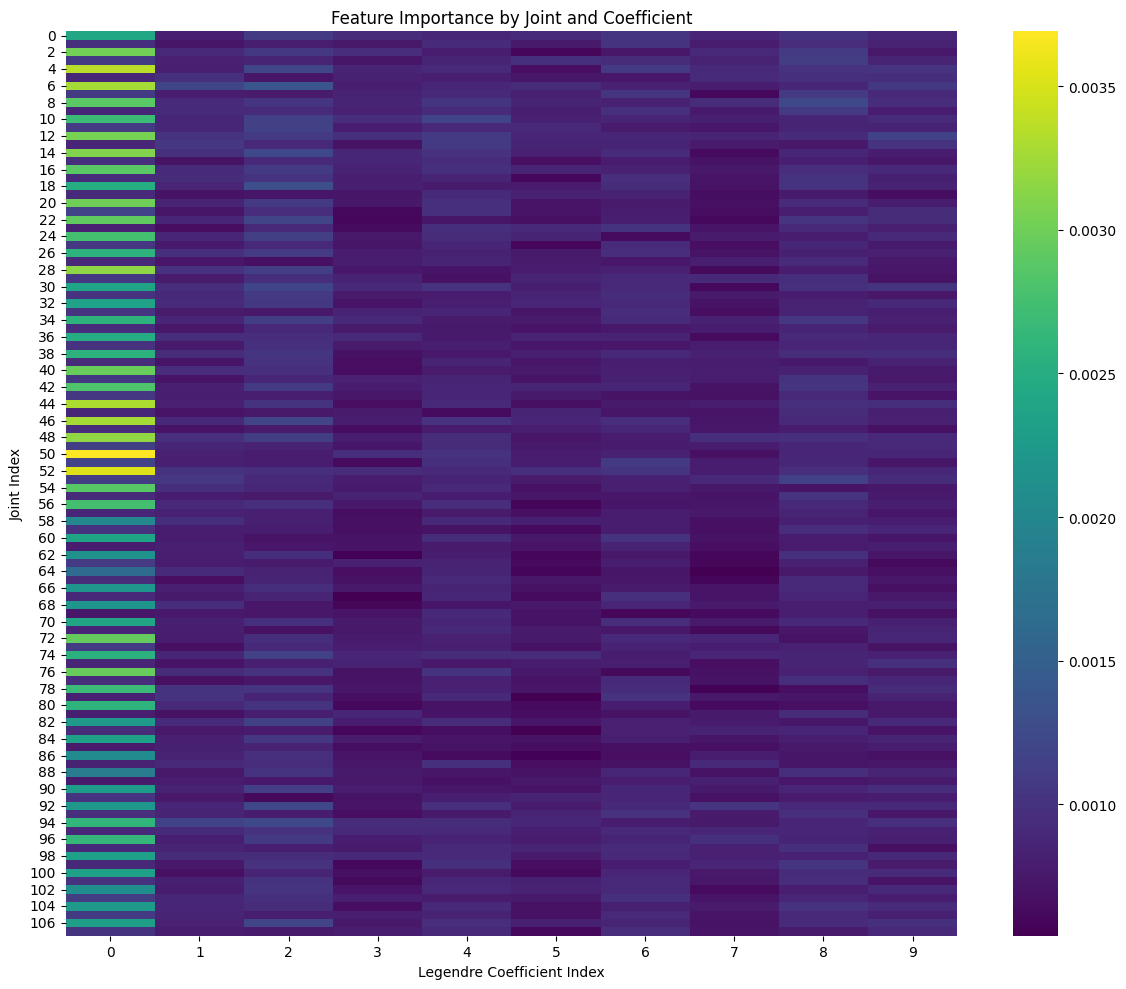

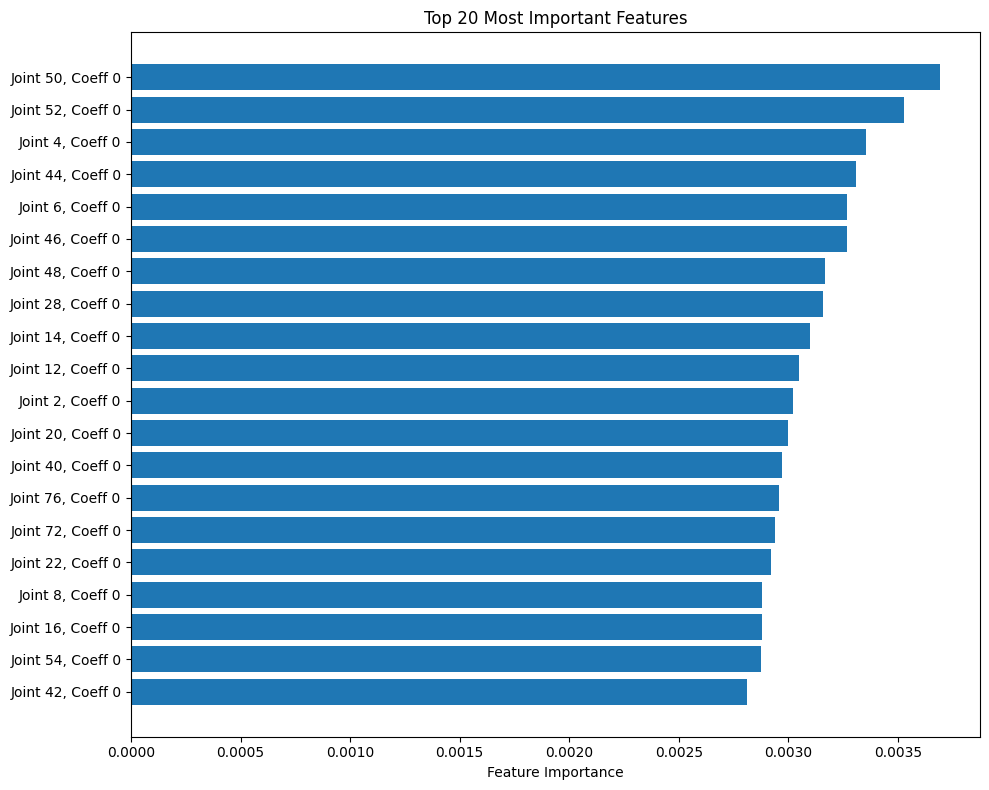

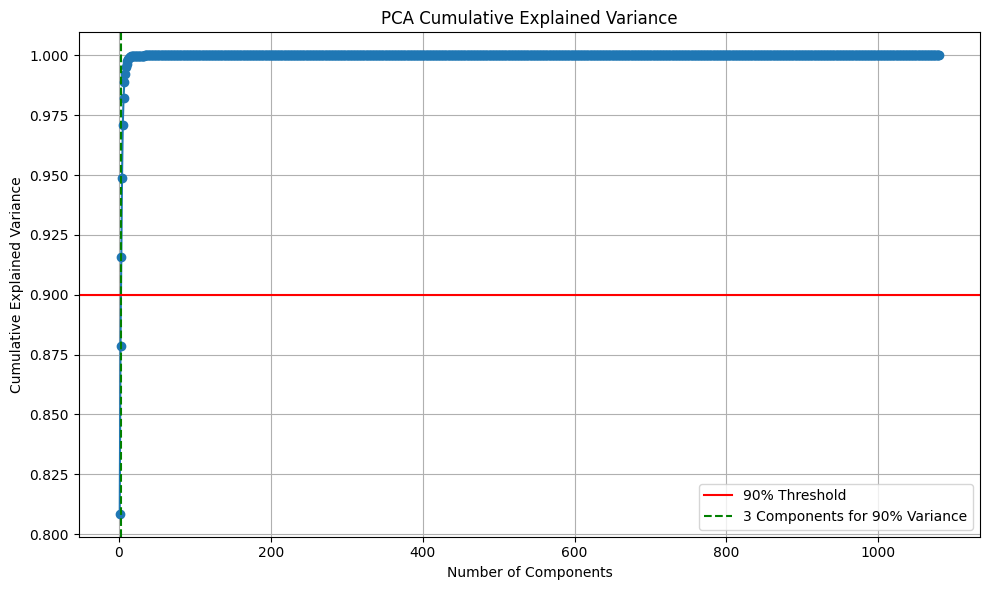

Number of PCA components needed to explain 90% of variance: 3


In [13]:

# Visualize feature importance
visualize_feature_importance(classifier, X, y)

# Additional analysis: PCA with more components to see cumulative explained variance
pca_full = PCA()
pca_full.fit(X)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='-', label='90% Threshold')
components_90 = np.where(cumulative_variance >= 0.9)[0][0] + 1
plt.axvline(x=components_90, color='g', linestyle='--', 
            label=f'{components_90} Components for 90% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('pca_cumulative_variance.png')
plt.show()

print(f"Number of PCA components needed to explain 90% of variance: {components_90}")

Original data shape: (6197, 540)
Interpreted as 54 joints × 10 Legendre coefficients
Data reduced from 540 to 17 dimensions
Explained variance with 17 components: 0.9001
Classification Accuracy: 0.2586

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.25      0.28        73
           1       0.36      0.52      0.43       143
           2       0.39      0.44      0.41        98
           3       0.22      0.30      0.26       155
           4       0.11      0.11      0.11        72
           5       0.36      0.40      0.38       115
           6       0.14      0.13      0.14        67
           7       0.35      0.23      0.28        84
           8       0.22      0.14      0.17        64
           9       0.07      0.04      0.05        75
          10       0.21      0.12      0.15        74
          11       0.19      0.19      0.19        74
          12       0.26      0.32      0.29        77
          13     

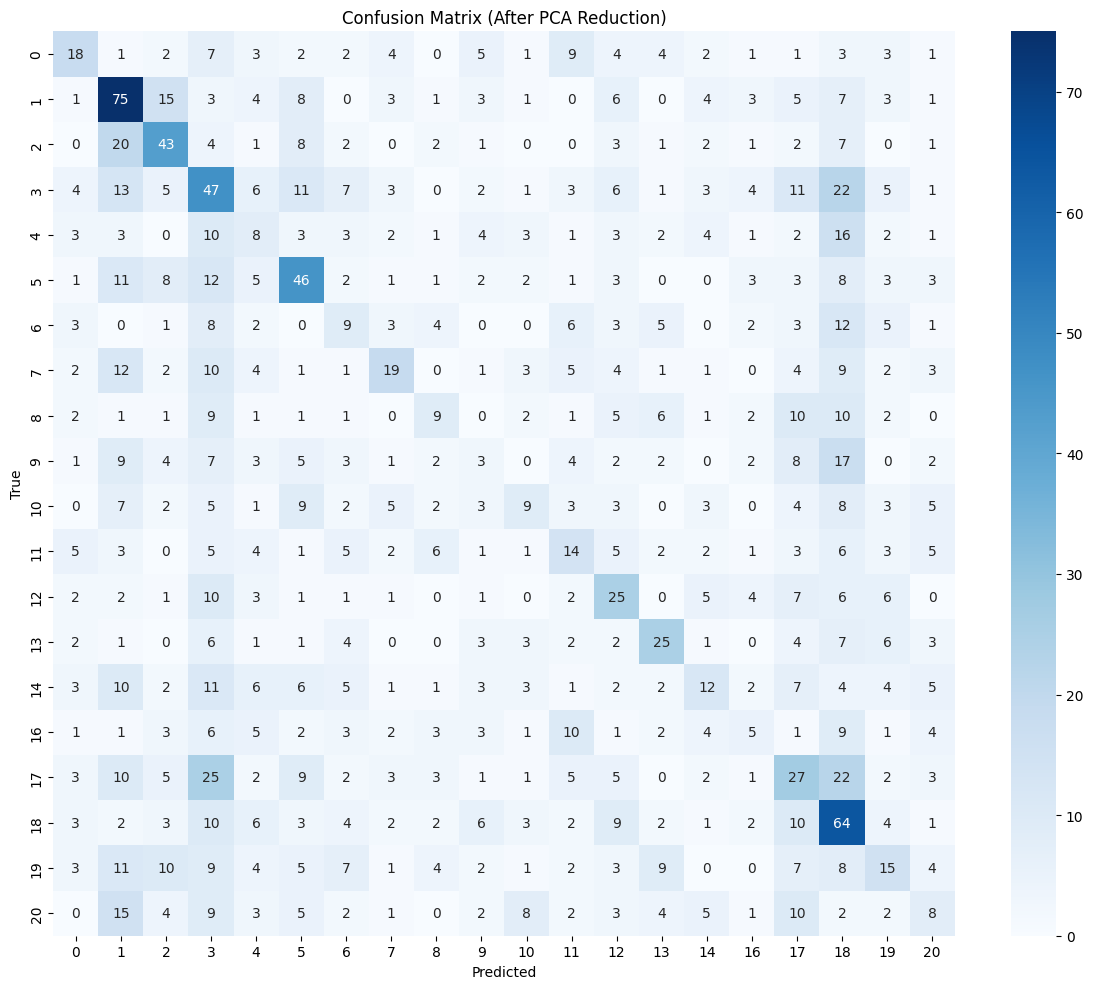

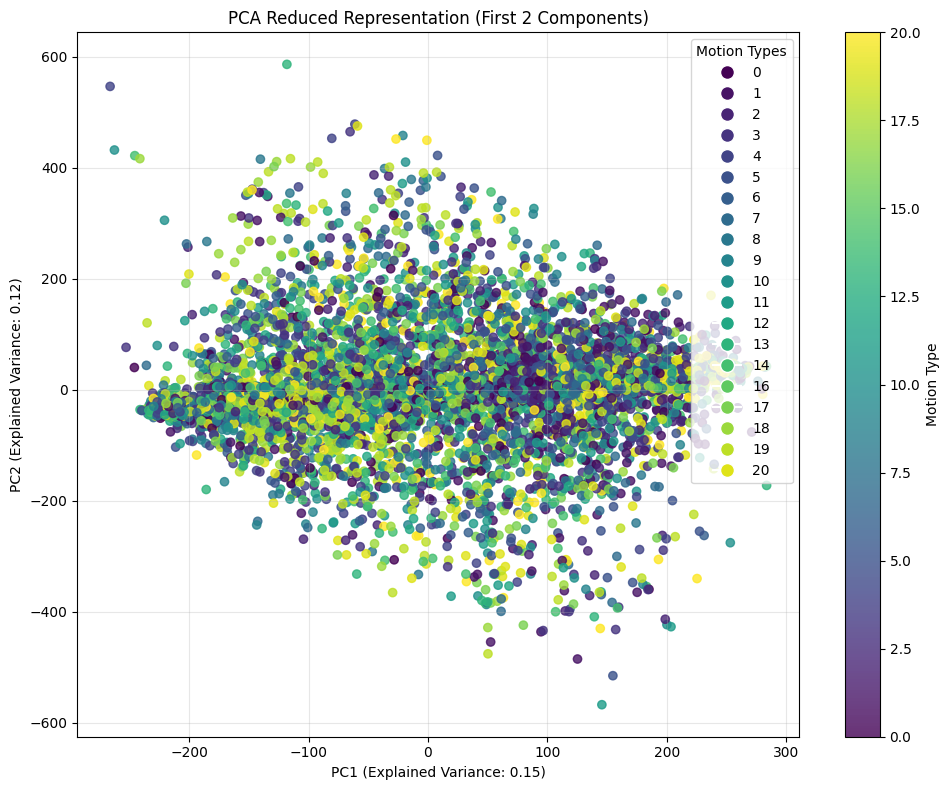

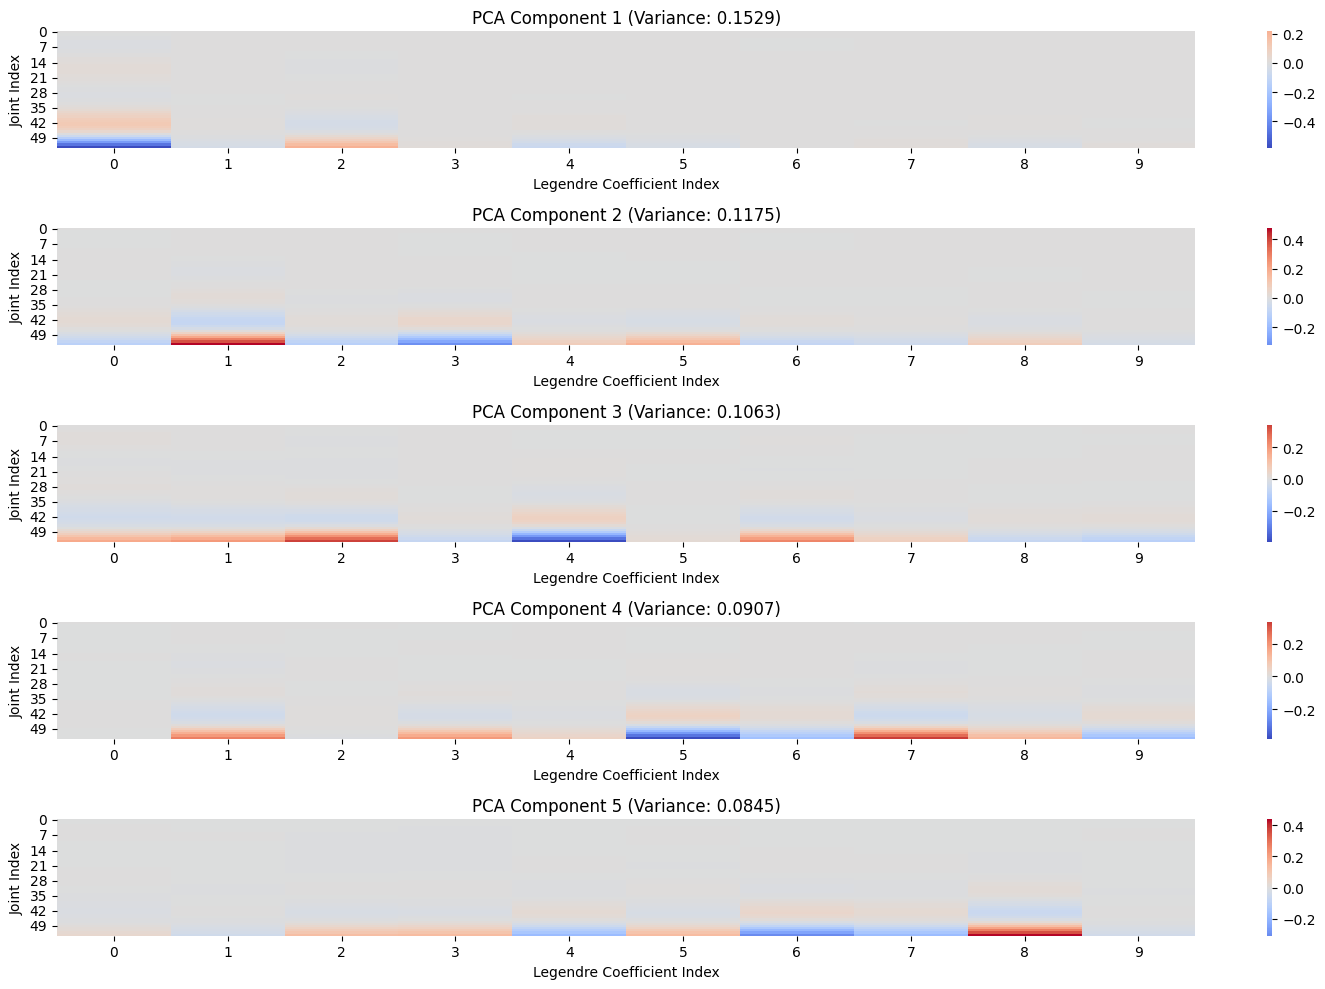

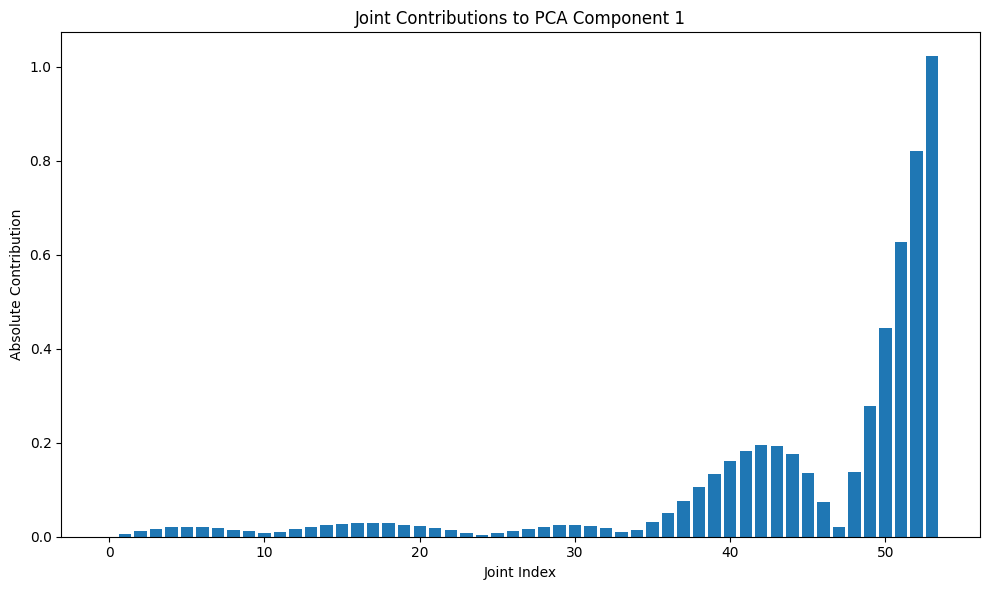

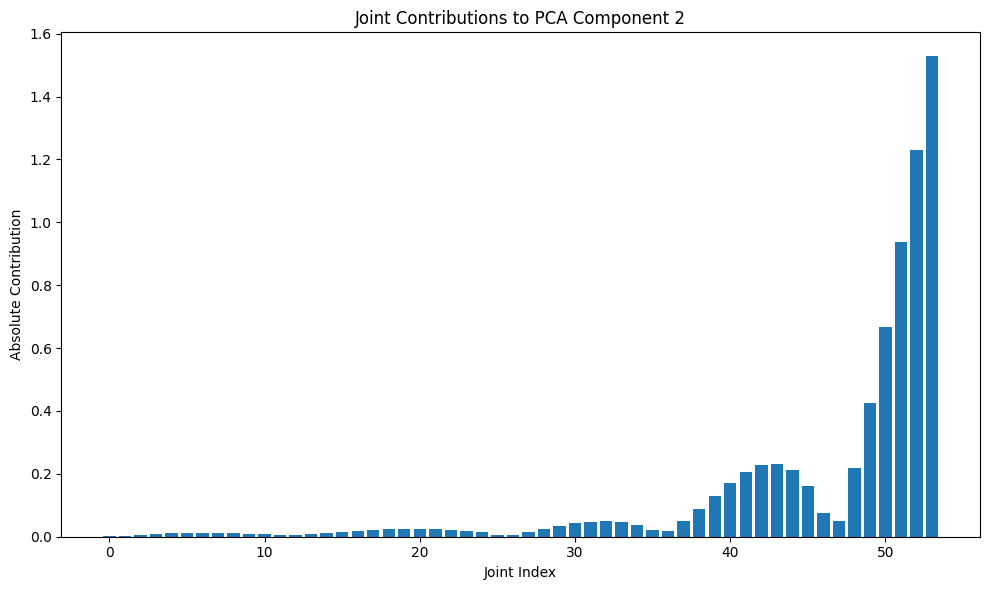

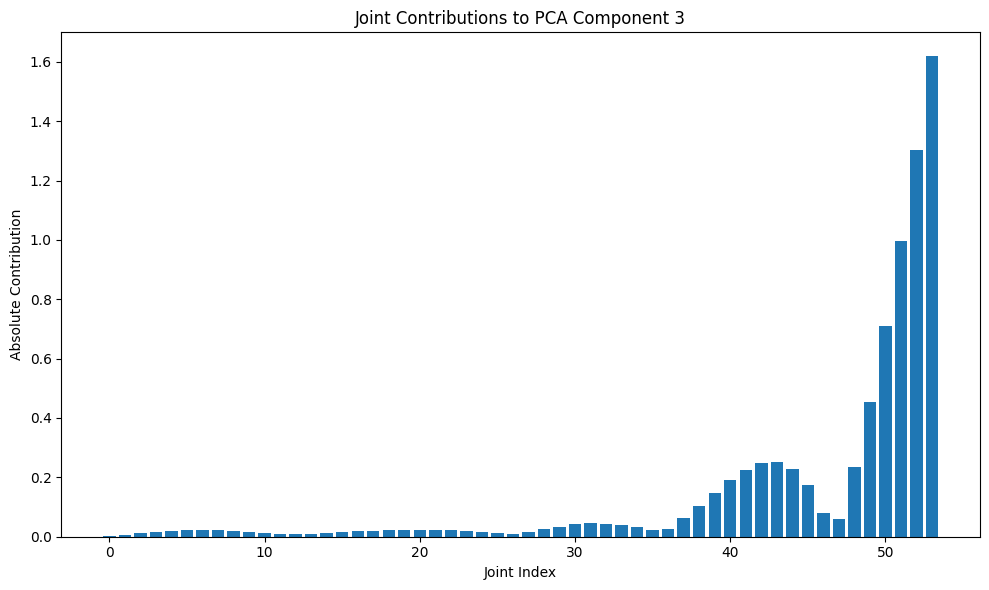

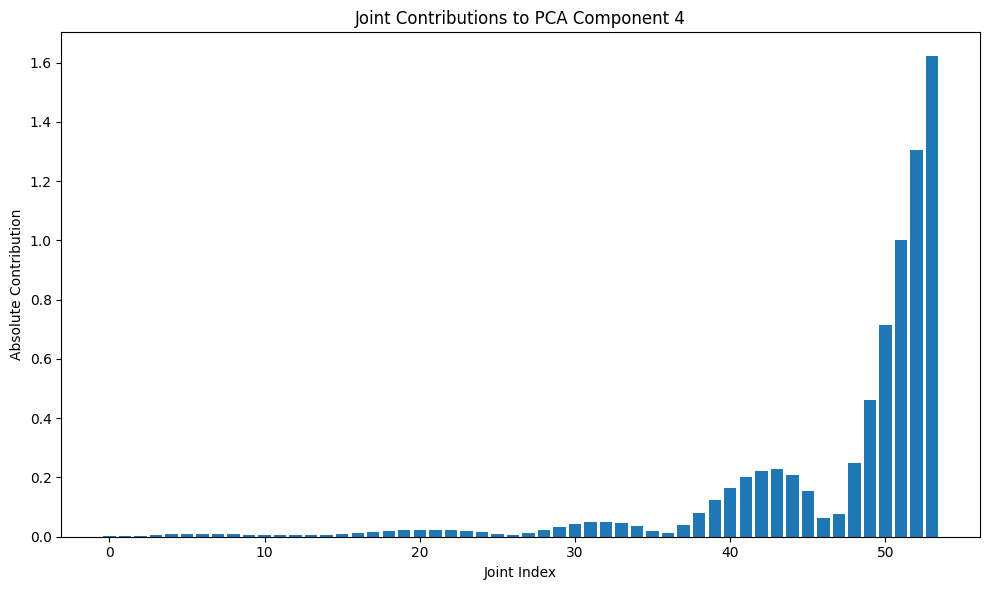

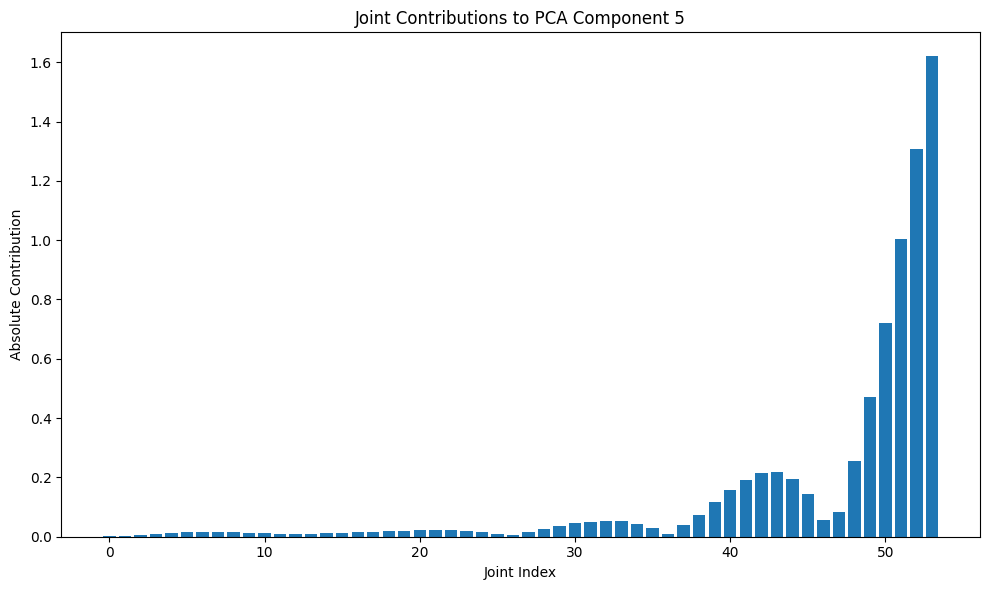


Classifier Comparison:
Random Forest: 0.2556 ± 0.0076
SVM: 0.0820 ± 0.0011
Neural Network: 0.1688 ± 0.0111


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def pca_reduction_and_classification(X, y, n_components=17):
    """
    Reduce dimensions with PCA and classify motion types.
    
    Parameters:
    - X: array of flattened coefficients
    - y: array of motion type labels
    - n_components: number of PCA components to use
    
    Returns:
    - pca: fitted PCA model
    - classifier: fitted classifier
    - accuracy: classification accuracy
    """
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    print(f"Data reduced from {X.shape[1]} to {X_pca.shape[1]} dimensions")
    print(f"Explained variance with {n_components} components: {sum(pca.explained_variance_ratio_):.4f}")
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y, test_size=0.3, random_state=42, stratify=y if len(np.unique(y)) > 1 else None
    )
    
    # Train a Random Forest classifier
    classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    classifier.fit(X_train, y_train)
    
    # Make predictions
    y_pred = classifier.predict(X_test)
    
    # Evaluate the classifier
    accuracy = np.mean(y_pred == y_test)
    print(f"Classification Accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Create confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (After PCA Reduction)')
    plt.tight_layout()
    plt.savefig('confusion_matrix_pca_reduced.png')
    plt.show()
    
    # Visualize the reduced data with first 2 components
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.8)
    
    # Add a colorbar
    plt.colorbar(scatter, label='Motion Type')
    
    # Add labels and title
    plt.xlabel(f'PC1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2f})')
    plt.ylabel(f'PC2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2f})')
    plt.title('PCA Reduced Representation (First 2 Components)')
    
    # Add legend for unique motion types
    unique_motions = np.unique(y)
    handles = [plt.Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=plt.cm.viridis(i / len(unique_motions)), 
                          markersize=10) for i in range(len(unique_motions))]
    plt.legend(handles, unique_motions, title='Motion Types')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('pca_reduced_visualization.png')
    plt.show()
    
    return pca, classifier, accuracy

def analyze_pca_components(pca, original_shape):
    """
    Analyze the PCA components in terms of their relationship to the original features.
    
    Parameters:
    - pca: fitted PCA model
    - original_shape: tuple (n_joints, n_coeffs) representing the original feature structure
    """
    n_joints, n_coeffs = original_shape
    
    # Visualize the component loadings
    plt.figure(figsize=(15, 10))
    
    # Display the first 5 components (or fewer if less available)
    n_display = min(5, pca.components_.shape[0])
    
    for i in range(n_display):
        plt.subplot(n_display, 1, i + 1)
        component = pca.components_[i].reshape(n_joints, n_coeffs)
        
        # Plot as heatmap
        sns.heatmap(component, cmap='coolwarm', center=0)
        plt.title(f'PCA Component {i+1} (Variance: {pca.explained_variance_ratio_[i]:.4f})')
        plt.xlabel('Legendre Coefficient Index')
        plt.ylabel('Joint Index')
    
    plt.tight_layout()
    plt.savefig('pca_component_analysis.png')
    plt.show()
    
    # Analyze which joints contribute most to the first few components
    n_top_components = min(5, pca.components_.shape[0])
    
    for i in range(n_top_components):
        component = pca.components_[i].reshape(n_joints, n_coeffs)
        joint_importance = np.sum(np.abs(component), axis=1)
        
        plt.figure(figsize=(10, 6))
        plt.bar(range(n_joints), joint_importance)
        plt.xlabel('Joint Index')
        plt.ylabel('Absolute Contribution')
        plt.title(f'Joint Contributions to PCA Component {i+1}')
        plt.tight_layout()
        plt.savefig(f'joint_contribution_component_{i+1}.png')
        plt.show()

# Main execution
# Assuming X and y are already defined from your previous code
# X, y = prepare_coefficient_data(coefficients, motion_ids)

# Determine the original shape (n_joints, n_coeffs)
n_coeffs = 10  # Since you're using 10 Legendre polynomial degrees
n_joints = X.shape[1] // n_coeffs
original_shape = (n_joints, n_coeffs)

print(f"Original data shape: {X.shape}")
print(f"Interpreted as {n_joints} joints × {n_coeffs} Legendre coefficients")

# Perform PCA reduction and classification
pca, classifier, accuracy = pca_reduction_and_classification(X, y, n_components=17)

# Analyze the PCA components
analyze_pca_components(pca, original_shape)

# Compare with other classification methods
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

# Apply PCA reduction
X_pca = pca.transform(X)

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(gamma='auto', random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

# Evaluate each classifier with cross-validation
print("\nClassifier Comparison:")
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_pca, y, cv=5)
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")

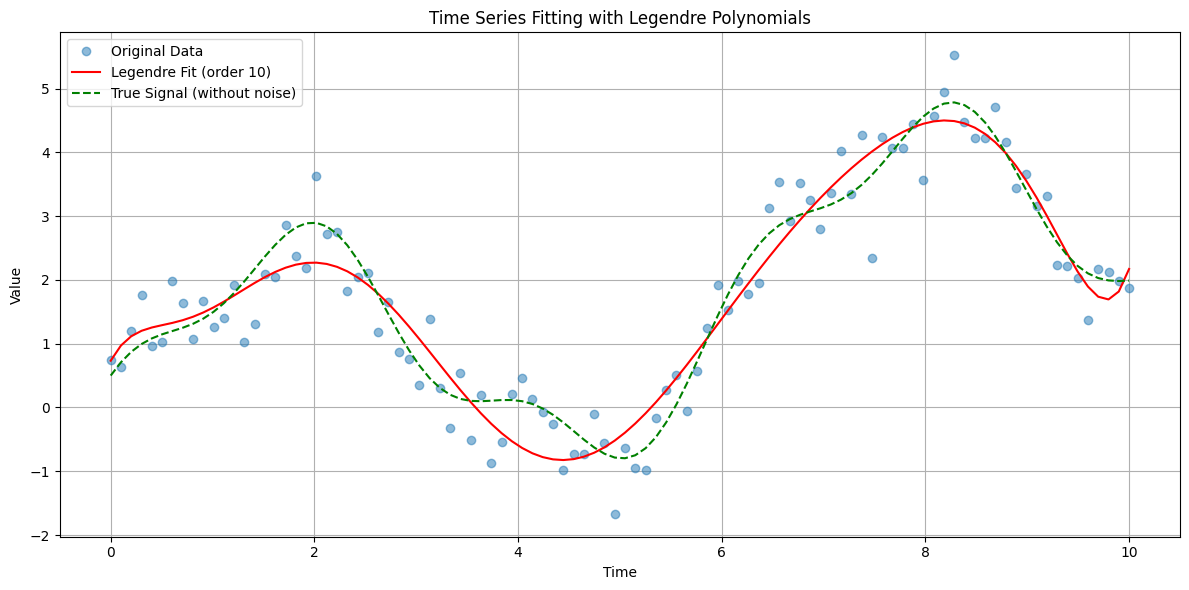

Root Mean Square Error: 0.5077
Variance Accounted For (VAF): 90.37%
VAF (alternative calculation): 90.37%


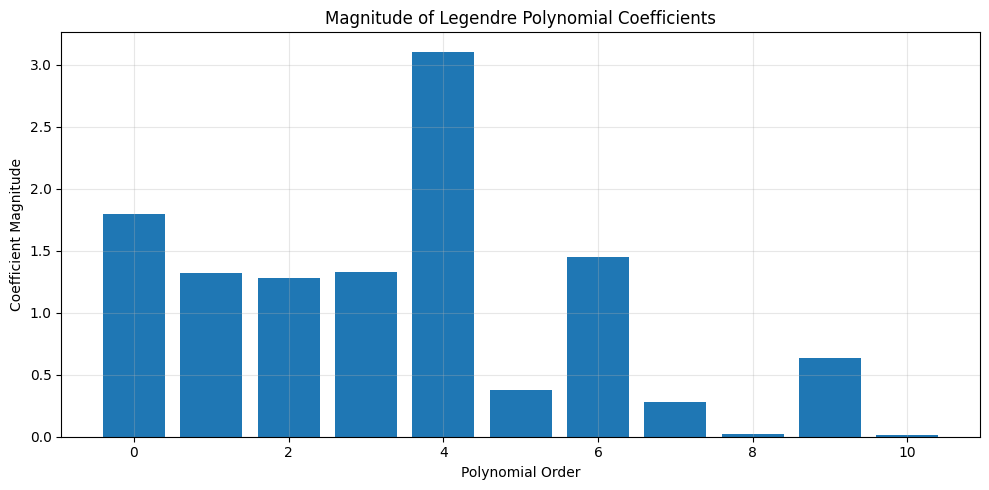

In [2]:


# Step 1: Generate sample time series data (or load your own)
np.random.seed(42)  # For reproducibility
n_points = 100
time = np.linspace(0, 10, n_points)
# Creating a complex signal with noise
true_signal = 2 * np.sin(time) + 0.5 * np.cos(3 * time) + 0.3 * time
noise = np.random.normal(0, 0.5, n_points)
data = true_signal + noise

# Step 2: Normalize time to [-1, 1] range
time_normalized = 2 * (time - np.min(time)) / (np.max(time) - np.min(time)) - 1

# Step 3: Define the order of Legendre polynomial expansion
order = 10  # You can adjust this based on your data complexity

# Step 4: Construct the design matrix
X = np.zeros((n_points, order + 1))
for i in range(order + 1):
    # Generate the ith Legendre polynomial
    P_i = legendre(i)
    X[:, i] = P_i(time_normalized)

# Step 5: Fit the coefficients using least squares
coefficients, residuals, rank, s = np.linalg.lstsq(X, data, rcond=None)

# Step 6: Compute the fitted values
fitted_values = X @ coefficients

# Step 7: Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time, data, 'o', alpha=0.5, label='Original Data')
plt.plot(time, fitted_values, 'r-', label=f'Legendre Fit (order {order})')
plt.plot(time, true_signal, 'g--', label='True Signal (without noise)')
plt.legend()
plt.title('Time Series Fitting with Legendre Polynomials')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 8: Evaluate the quality of the fit
mse = np.mean((fitted_values - data) ** 2)
rmse = np.sqrt(mse)
print(f"Root Mean Square Error: {rmse:.4f}")

# Calculate Variance Accounted For (VAF)
# VAF is similar to R-squared and measures the proportion of variance explained by the model
total_variance = np.var(data)
residual_variance = np.var(data - fitted_values)
vaf = 100 * (1 - residual_variance / total_variance)
print(f"Variance Accounted For (VAF): {vaf:.2f}%")

# Alternative calculation using the formula: 1 - SSE/SST
sse = np.sum((data - fitted_values) ** 2)  # Sum of squared errors
sst = np.sum((data - np.mean(data)) ** 2)  # Total sum of squares
vaf_alt = 100 * (1 - sse / sst)
print(f"VAF (alternative calculation): {vaf_alt:.2f}%")

# Step 9: Predict for new values (if needed)
def predict(new_time, coefficients, original_time_min, original_time_max):
    """Make predictions at new time points using the fitted Legendre model"""
    # Normalize the new time points
    new_time_normalized = 2 * (new_time - original_time_min) / (original_time_max - original_time_min) - 1
    
    # Create the design matrix for the new points
    X_new = np.zeros((len(new_time), len(coefficients)))
    for i in range(len(coefficients)):
        P_i = legendre(i)
        X_new[:, i] = P_i(new_time_normalized)
    
    # Calculate predictions
    predictions = X_new @ coefficients
    return predictions

# Example of making predictions
future_time = np.linspace(10, 12, 20)  # Predict beyond the original time range
predictions = predict(future_time, coefficients, np.min(time), np.max(time))

# plt.figure(figsize=(12, 6))
# plt.plot(time, data, 'o', alpha=0.5, label='Original Data')
# plt.plot(time, fitted_values, 'r-', label='Legendre Fit')
# plt.plot(future_time, predictions, 'b-', label='Predictions')
# plt.axvline(x=10, color='k', linestyle='--', alpha=0.3)  # Mark the boundary between data and predictions
# plt.legend()
# plt.title('Time Series Prediction with Legendre Polynomials')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# Step 10: Analyze the coefficients
plt.figure(figsize=(10, 5))
plt.bar(range(len(coefficients)), np.abs(coefficients))
plt.xlabel('Polynomial Order')
plt.ylabel('Coefficient Magnitude')
plt.title('Magnitude of Legendre Polynomial Coefficients')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [3]:
import numpy as np


def fit_legendre(time, data, order, plot=True, title="Time Series Fitting with Legendre Polynomials"):
    """
    Fit Legendre polynomials to time series data.
    
    Parameters:
    -----------
    time : array-like
        The time points of the data.
    data : array-like
        The observed values at each time point.
    order : int
        The order of Legendre polynomial expansion (number of terms - 1).
    plot : bool, optional (default=True)
        Whether to generate and display the fitting plot.
    title : str, optional
        The title for the plot.
        
    Returns:
    --------
    dict
        A dictionary containing:
        - 'coefficients': The fitted Legendre polynomial coefficients
        - 'fitted_values': The fitted values at each time point
        - 'vaf': Variance Accounted For (percentage)
        - 'rmse': Root Mean Square Error
        - 'residuals': The residuals (data - fitted_values)
        - 'normalized_time': The normalized time values used for fitting
        - 'design_matrix': The design matrix of Legendre polynomials
    """
    # Convert inputs to numpy arrays if they aren't already
    time = np.array(time)
    data = np.array(data)
    
    # Step 1: Normalize time to [-1, 1] range
    time_min, time_max = np.min(time), np.max(time)
    time_normalized = 2 * (time - time_min) / (time_max - time_min) - 1
    
    # Step 2: Construct the design matrix
    X = np.zeros((len(time), order + 1))
    for i in range(order + 1):
        # Generate the ith Legendre polynomial
        P_i = legendre(i)
        X[:, i] = P_i(time_normalized)
    
    # Step 3: Fit the coefficients using least squares
    coefficients, residuals, rank, s = np.linalg.lstsq(X, data, rcond=None)
    
    # Step 4: Compute the fitted values
    fitted_values = X @ coefficients
    
    # Step 5: Calculate error metrics
    residuals = data - fitted_values
    mse = np.mean(residuals ** 2)
    rmse = np.sqrt(mse)
    
    # Calculate Variance Accounted For (VAF)
    total_variance = np.var(data)
    residual_variance = np.var(residuals)
    vaf = 100 * (1 - residual_variance / total_variance)
    
    # Calculate Sum of Squared Error
    sse = np.sum(residuals ** 2)
    
    # Step 6: Plot the results if requested
    if plot:
        plt.figure(figsize=(12, 8))
        
        # Plot original data and fitted values
        plt.plot(time, data, 'o', alpha=0.5, label='Original Data')
        plt.plot(time, fitted_values, 'r-', linewidth=2, label=f'Legendre Fit (order {order})')
        
        # Add labels and title
        plt.legend(fontsize=12)
        plt.title(title, fontsize=14)
        plt.xlabel('Time', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Add text box with metrics
        metrics_text = f"VAF: {vaf:.2f}%\nRMSE: {rmse:.4f}\nSSE: {sse:.4f}"
        plt.figtext(0.15, 0.15, metrics_text, fontsize=12, 
                   bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
        
        plt.tight_layout()
        plt.show()
        
        # Also plot the coefficient magnitudes
        plt.figure(figsize=(10, 5))
        plt.bar(range(len(coefficients)), np.abs(coefficients))
        plt.xlabel('Polynomial Order', fontsize=12)
        plt.ylabel('Coefficient Magnitude', fontsize=12)
        plt.title('Magnitude of Legendre Polynomial Coefficients', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Return results in a dictionary
    results = {
        'coefficients': coefficients,
        'fitted_values': fitted_values,
        'vaf': vaf,
        'rmse': rmse,
        'sse': sse,
        'residuals': residuals,
        'normalized_time': time_normalized,
        'design_matrix': X
    }
    
    return results



In [7]:

# Example usage
if __name__ == "__main__":
    # Generate sample time series data
    np.random.seed(42)  # For reproducibility
    n_points = 100
    time = np.linspace(0, 10, n_points)
    
    # Creating a complex signal with noise
    true_signal = 2 * np.sin(time) + 0.5 * np.cos(3 * time) + 0.3 * time
    noise = np.random.normal(0, 0.5, n_points)
    data = true_signal + noise
    
    # Fit with different orders and compare
    results_order_10 = fit_legendre(time, data, order=10,plot=False, title="Legendre Fit with Order 10")
   
    # Print comparison of VAF for different orders
    print(f"Order 10 - VAF: {results_order_10['vaf']:.2f}%, RMSE: {results_order_10['rmse']:.4f}")
   

Order 10 - VAF: 90.37%, RMSE: 0.5077


In [4]:
destination_folder = "../../data/MMpose/segmented_files/walking/bvh_files"
folder_path = "../../../movement_repo/data/MMpose/bvh_files" 
folder_path = destination_folder  
bvh_data = read_bvh_files(folder_path)

processed_data = process_bvh_data(bvh_data)
num_segments = len(processed_data)
# based on TMP code: the format of data=list(segment_data[signals,time]) --> signals are fixed but time 
# could vary in segments
# as far as i underastand:
# num segments = number of videos segment we have (all segments*each subject)
# num_signals =  number of sensors/signals. = number of features / joint info in data = 54 here
print(f'num of segments : {num_segments}')
num_signals = processed_data[0].shape[0]
print(f'num of signal : {num_signals}')

num of segments : 327
num of signal : 54


In [5]:
import numpy as np
from matplotlib.gridspec import GridSpec

def fit_legendre_to_signal(time_points, signal_data, order):
    """
    Fit Legendre polynomials to a single signal.
    
    Parameters:
    -----------
    time_points : array-like
        The time points of the signal.
    signal_data : array-like
        The signal values at each time point.
    order : int
        The order of Legendre polynomial expansion.
        
    Returns:
    --------
    dict
        Dictionary with fitting results.
    """
    # Normalize time to [-1, 1] range
    time_min, time_max = np.min(time_points), np.max(time_points)
    time_normalized = 2 * (time_points - time_min) / (time_max - time_min) - 1
    
    # Construct the design matrix
    X = np.zeros((len(time_points), order + 1))
    for i in range(order + 1):
        P_i = legendre(i)
        X[:, i] = P_i(time_normalized)
    
    # Fit using least squares
    coefficients, residuals, rank, s = np.linalg.lstsq(X, signal_data, rcond=None)
    
    # Calculate fitted values
    fitted_values = X @ coefficients
    
    # Calculate metrics
    residuals = signal_data - fitted_values
    mse = np.mean(residuals ** 2)
    rmse = np.sqrt(mse)
    
    # Calculate VAF
    total_variance = np.var(signal_data)
    residual_variance = np.var(residuals)
    # Handle cases where total_variance is too small
    if total_variance < 1e-10:
        vaf = 100.0 if residual_variance < 1e-10 else 0.0
    else:
        vaf = 100 * (1 - residual_variance / total_variance)
    
    return {
        'coefficients': coefficients,
        'fitted_values': fitted_values,
        'vaf': vaf,
        'rmse': rmse,
        'residuals': residuals,
        'normalized_time': time_normalized
    }

def analyze_mocap_segments(processed_data, poly_order, signal_names=None, plot_summary=True, plot_details=False, max_signals_to_plot=10):
    """
    Analyze motion capture data segments using Legendre polynomials.
    
    Parameters:
    -----------
    processed_data : list
        List of numpy arrays, where each array has shape [num_signals, time_points]
    poly_order : int
        The order of Legendre polynomial expansion.
    signal_names : list, optional
        Names of the signals/joints.
    plot_summary : bool, optional
        Whether to plot the summary of VAF across segments.
    plot_details : bool, optional
        Whether to plot detailed fitting for selected signals.
    max_signals_to_plot : int, optional
        Maximum number of signals to plot in detail.
        
    Returns:
    --------
    dict
        A dictionary containing VAF results for all segments and signals.
    """
    num_segments = len(processed_data)
    if num_segments == 0:
        raise ValueError("No data segments provided")
    
    num_signals = processed_data[0].shape[0]
    
    # If signal names are not provided, create generic names
    if signal_names is None:
        signal_names = [f"Signal_{i+1}" for i in range(num_signals)]
    elif len(signal_names) != num_signals:
        print(f"Warning: {len(signal_names)} signal names provided, but data has {num_signals} signals")
        # Extend or truncate signal_names as needed
        if len(signal_names) < num_signals:
            signal_names.extend([f"Signal_{i+1}" for i in range(len(signal_names), num_signals)])
        else:
            signal_names = signal_names[:num_signals]
    
    # Store results for all segments and signals
    all_results = {
        'segment_results': [],
        'overall_vaf_by_signal': np.zeros(num_signals),
        'overall_vaf_by_segment': np.zeros(num_segments),
        'signal_names': signal_names
    }
    
    # Process each segment
    for segment_idx, segment_data in enumerate(processed_data):
        # Create time points array (assuming uniform sampling)
        time_points = np.arange(segment_data.shape[1])
        
        # Store results for this segment
        segment_results = {
            'segment_id': segment_idx + 1,
            'segment_length': len(time_points),
            'signal_results': [],
            'mean_vaf': 0.0
        }
        
        total_vaf = 0.0
        
        # Process each signal in this segment
        for signal_idx in range(num_signals):
            signal_data = segment_data[signal_idx]
            
            # Check if we can fit (need more points than order)
            if len(time_points) <= poly_order:
                print(f"Warning: Segment {segment_idx+1} has fewer points ({len(time_points)}) "
                      f"than polynomial order + 1 ({poly_order+1}). Reducing order.")
                curr_order = len(time_points) - 2  # Ensure we have at least order+1 points
                if curr_order < 1:
                    print(f"Skipping fitting for segment {segment_idx+1}, signal {signal_idx+1} due to insufficient data")
                    signal_result = {
                        'signal_id': signal_idx + 1,
                        'signal_name': signal_names[signal_idx],
                        'vaf': 0.0,
                        'rmse': float('inf'),
                        'order': 0,
                        'coefficients': []
                    }
                    segment_results['signal_results'].append(signal_result)
                    continue
            else:
                curr_order = poly_order
            
            # Fit Legendre polynomial to this signal
            fit_result = fit_legendre_to_signal(time_points, signal_data, curr_order)
            
            # Store results
            signal_result = {
                'signal_id': signal_idx + 1,
                'signal_name': signal_names[signal_idx],
                'vaf': fit_result['vaf'],
                'rmse': fit_result['rmse'],
                'order': curr_order,
                'coefficients': fit_result['coefficients'],
                'fitted_values': fit_result['fitted_values'],
                'residuals': fit_result['residuals']
            }
            
            segment_results['signal_results'].append(signal_result)
            total_vaf += fit_result['vaf']
        
        # Calculate mean VAF for this segment
        segment_results['mean_vaf'] = total_vaf / num_signals
        all_results['segment_results'].append(segment_results)
        all_results['overall_vaf_by_segment'][segment_idx] = segment_results['mean_vaf']
    
    # Calculate overall VAF by signal across all segments
    for signal_idx in range(num_signals):
        signal_vaf_sum = 0.0
        count = 0
        for segment_results in all_results['segment_results']:
            signal_result = segment_results['signal_results'][signal_idx]
            if signal_result['order'] > 0:  # Only count if we actually fitted
                signal_vaf_sum += signal_result['vaf']
                count += 1
        
        if count > 0:
            all_results['overall_vaf_by_signal'][signal_idx] = signal_vaf_sum / count
    
    # Calculate overall mean VAF
    all_results['overall_mean_vaf'] = np.mean(all_results['overall_vaf_by_signal'])
    
    # Create summary visualizations
    if plot_summary:
        plot_mocap_summary(all_results)
    
    # Create detailed visualizations for a subset of signals
    if plot_details:
        # Select signals with diverse VAF scores to plot
        vaf_scores = all_results['overall_vaf_by_signal']
        signal_indices = np.argsort(vaf_scores)
        
        # Pick signals across the range (low, medium, high VAF)
        num_to_plot = min(max_signals_to_plot, num_signals)
        if num_to_plot <= 3:
            indices_to_plot = signal_indices[::max(1, len(signal_indices)//num_to_plot)][:num_to_plot]
        else:
            # Get some low, some medium, and some high VAF signals
            low_idx = signal_indices[:max(1, num_to_plot//3)]
            mid_idx = signal_indices[len(signal_indices)//2-max(1, num_to_plot//6):len(signal_indices)//2+max(1, num_to_plot//6)]
            high_idx = signal_indices[-max(1, num_to_plot//3):]
            
            # Combine and limit to max_signals_to_plot
            indices_to_plot = np.concatenate([low_idx, mid_idx, high_idx])[:num_to_plot]
        
        # Plot detailed fits for selected signals
        for signal_idx in indices_to_plot:
            plot_signal_details(processed_data, signal_idx, signal_names[signal_idx], 
                               all_results['segment_results'], poly_order)
    
    return all_results

def plot_mocap_summary(results):
    """Plot summary visualizations of the VAF analysis."""
    num_segments = len(results['segment_results'])
    num_signals = len(results['signal_names'])
    
    plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 2, height_ratios=[1, 1.5])
    
    # 1. Overall VAF by segment
    ax1 = plt.subplot(gs[0, 0])
    segment_ids = np.arange(1, num_segments + 1)
    ax1.bar(segment_ids, results['overall_vaf_by_segment'], color='cornflowerblue')
    ax1.set_xlabel('Segment ID')
    ax1.set_ylabel('Mean VAF (%)')
    ax1.set_title('Mean Variance Accounted For by Segment')
    ax1.set_xticks(segment_ids)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add text labels
    for i, vaf in enumerate(results['overall_vaf_by_segment']):
        ax1.text(i + 1, vaf + 1, f'{vaf:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 2. Histogram of VAF distribution
    ax2 = plt.subplot(gs[0, 1])
    all_vaf_values = []
    for segment_results in results['segment_results']:
        for signal_result in segment_results['signal_results']:
            if signal_result['order'] > 0:  # Only include if we actually fitted
                all_vaf_values.append(signal_result['vaf'])
    
    ax2.hist(all_vaf_values, bins=20, color='lightseagreen', alpha=0.7)
    ax2.set_xlabel('VAF (%)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of VAF Values Across All Signals and Segments')
    ax2.grid(True, alpha=0.3)
    ax2.axvline(results['overall_mean_vaf'], color='red', linestyle='--', 
                label=f'Mean: {results["overall_mean_vaf"]:.1f}%')
    ax2.legend()
    
    # 3. Heatmap of VAF by signal and segment
    ax3 = plt.subplot(gs[1, :])
    vaf_matrix = np.zeros((num_segments, num_signals))
    
    for i, segment_results in enumerate(results['segment_results']):
        for j, signal_result in enumerate(segment_results['signal_results']):
            vaf_matrix[i, j] = signal_result['vaf']
    
    im = ax3.imshow(vaf_matrix, aspect='auto', cmap='viridis', vmin=0, vmax=100)
    plt.colorbar(im, ax=ax3, label='VAF (%)')
    
    # Only show a subset of signal names if there are too many
    if num_signals > 20:
        step = max(1, num_signals // 20)
        signal_indices = np.arange(0, num_signals, step)
        signal_labels = [results['signal_names'][i] for i in signal_indices]
        ax3.set_xticks(signal_indices)
        ax3.set_xticklabels(signal_labels, rotation=90)
    else:
        ax3.set_xticks(np.arange(num_signals))
        ax3.set_xticklabels(results['signal_names'], rotation=90)
    
    ax3.set_yticks(np.arange(num_segments))
    ax3.set_yticklabels([f'Segment {i+1}' for i in range(num_segments)])
    ax3.set_xlabel('Signal')
    ax3.set_ylabel('Segment')
    ax3.set_title('VAF (%) by Signal and Segment')
    
    plt.tight_layout()
    plt.show()

def plot_signal_details(processed_data, signal_idx, signal_name, segment_results, poly_order):
    """Plot detailed visualizations for a single signal across segments."""
    num_segments = len(processed_data)
    plt.figure(figsize=(15, 4 * min(num_segments, 3)))
    
    # Create a grid of subplots (up to 3 rows, then add columns as needed)
    rows = min(num_segments, 3)
    cols = int(np.ceil(num_segments / 3))
    
    for segment_idx, segment_data in enumerate(processed_data):
        ax = plt.subplot(rows, cols, segment_idx + 1)
        
        # Get time points
        time_points = np.arange(segment_data.shape[1])
        
        # Original signal data
        signal_data = segment_data[signal_idx]
        ax.plot(time_points, signal_data, 'o', alpha=0.5, color='gray', label='Original')
        
        # Get fitted data from results
        fitted_values = segment_results[segment_idx]['signal_results'][signal_idx]['fitted_values']
        vaf = segment_results[segment_idx]['signal_results'][signal_idx]['vaf']
        
        # Plot fitted curve
        ax.plot(time_points, fitted_values, '-', linewidth=2, color='red', 
                label=f'Legendre (order={poly_order})')
        
        ax.set_title(f'Segment {segment_idx+1} - {signal_name}\nVAF: {vaf:.1f}%')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    plt.show()



Skipping fitting for segment 237, signal 1 due to insufficient data
Skipping fitting for segment 237, signal 2 due to insufficient data
Skipping fitting for segment 237, signal 3 due to insufficient data
Skipping fitting for segment 237, signal 4 due to insufficient data
Skipping fitting for segment 237, signal 5 due to insufficient data
Skipping fitting for segment 237, signal 6 due to insufficient data
Skipping fitting for segment 237, signal 7 due to insufficient data
Skipping fitting for segment 237, signal 8 due to insufficient data
Skipping fitting for segment 237, signal 9 due to insufficient data
Skipping fitting for segment 237, signal 10 due to insufficient data
Skipping fitting for segment 237, signal 11 due to insufficient data
Skipping fitting for segment 237, signal 12 due to insufficient data
Skipping fitting for segment 237, signal 13 due to insufficient data
Skipping fitting for segment 237, signal 14 due to insufficient data
Skipping fitting for segment 237, signal 15

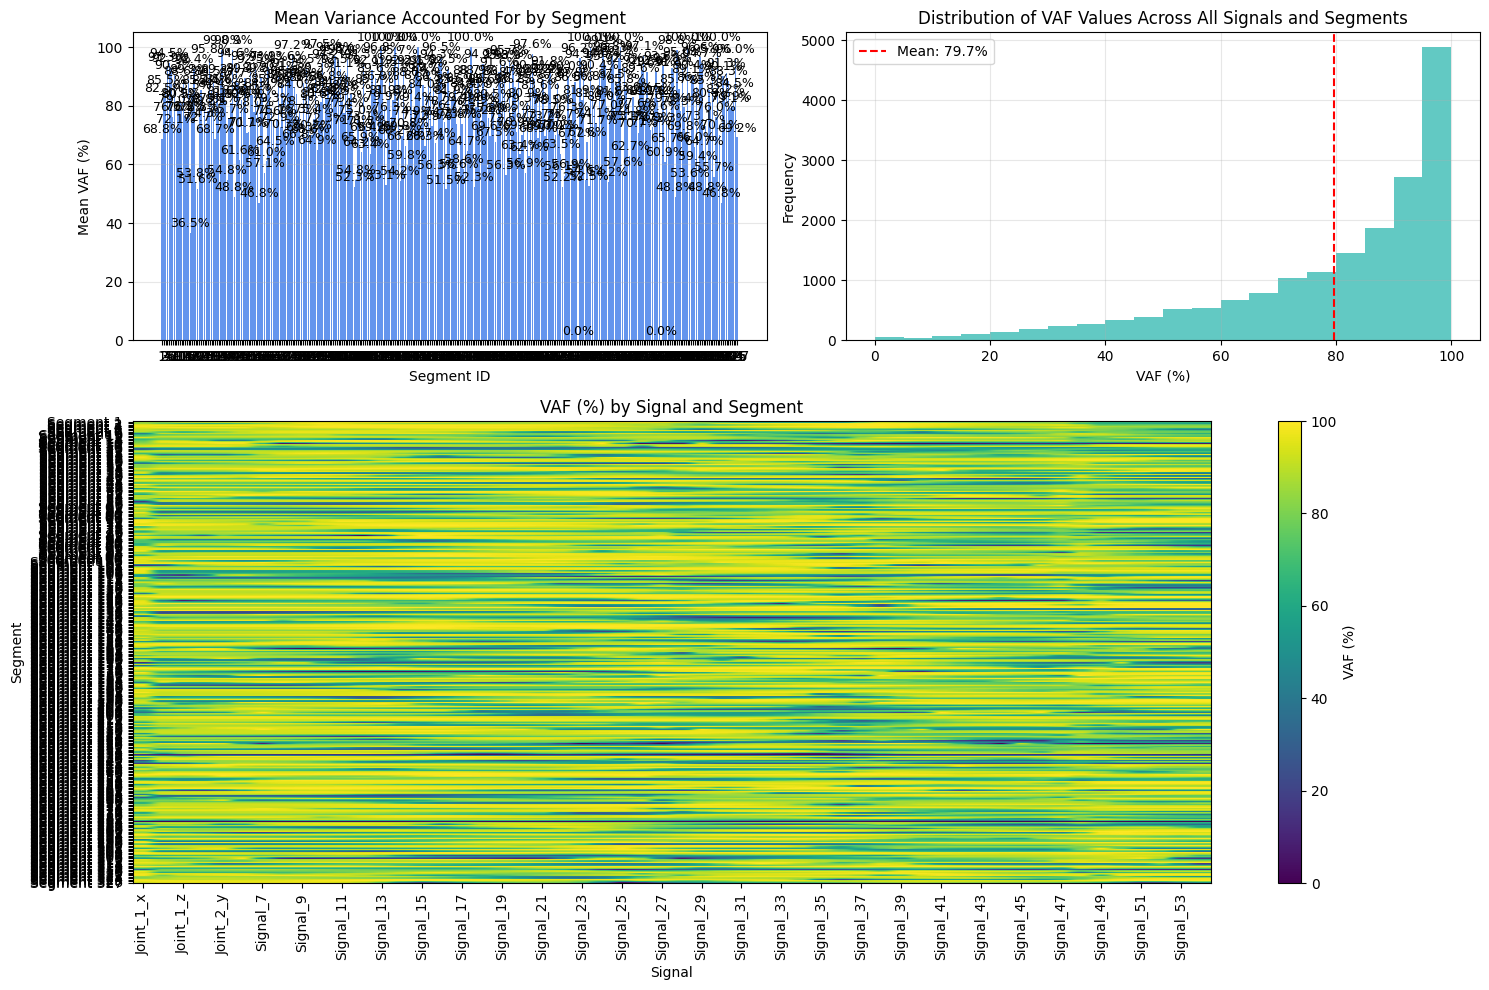

KeyError: 'fitted_values'

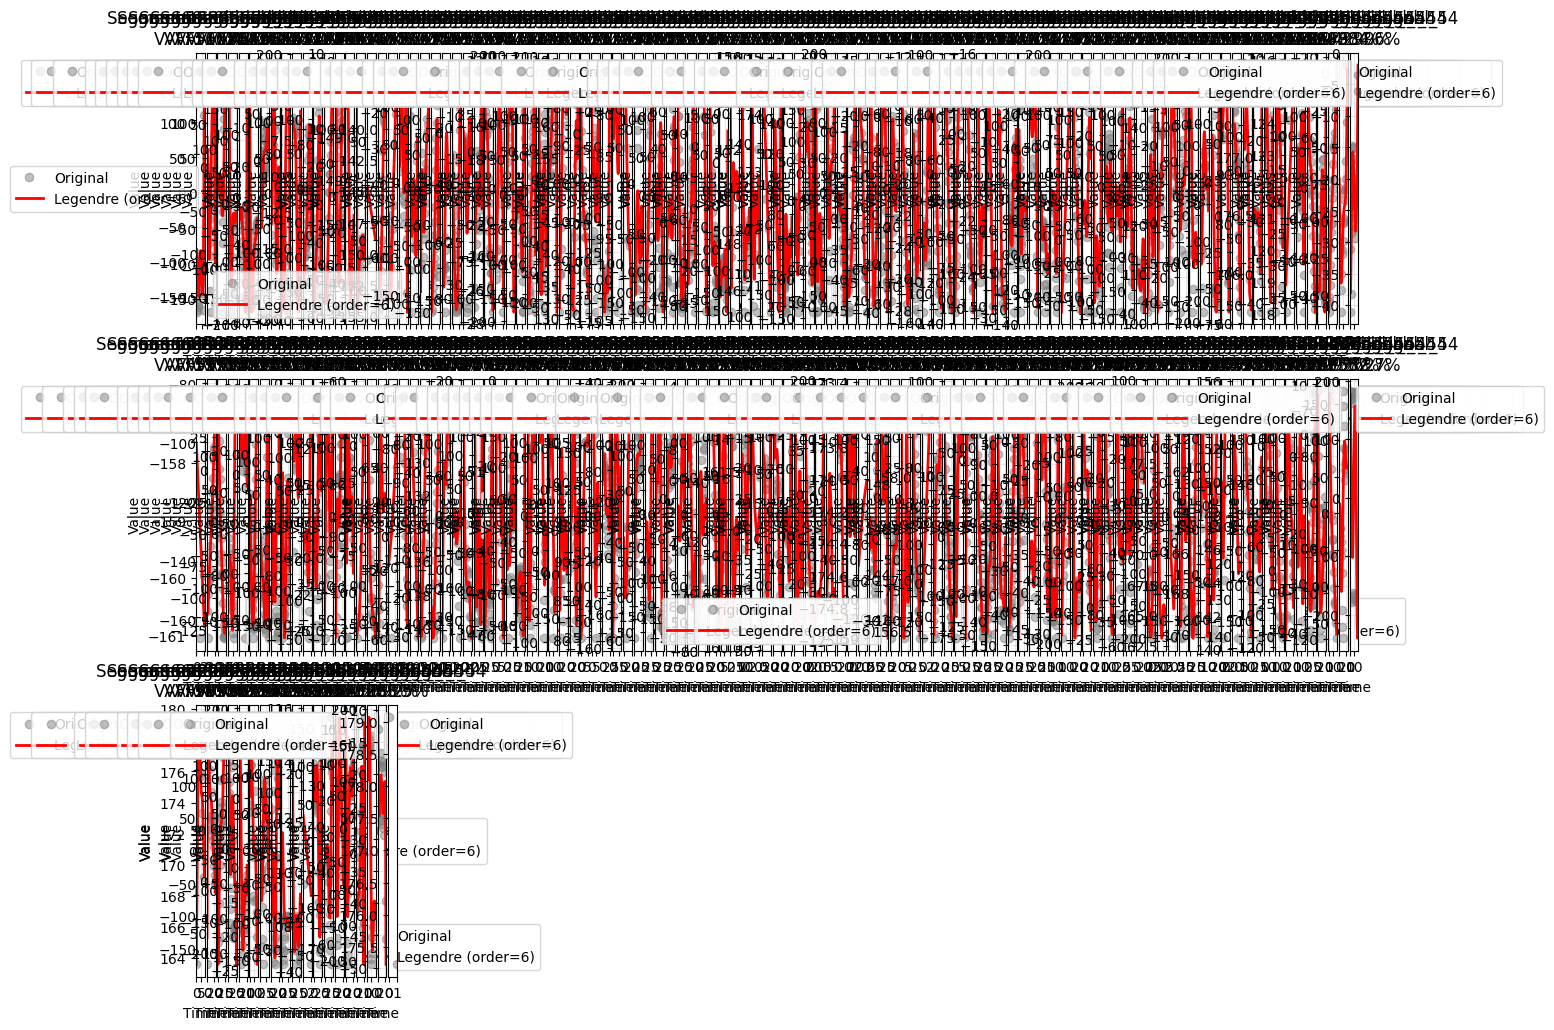

In [6]:


# Main execution
if __name__ == "__main__":
    # Use the path provided in your snippet
    destination_folder = "../../data/MMpose/segmented_files/walking/bvh_files"
    folder_path = destination_folder
    
    # Read BVH files (replace with your actual implementation)
    bvh_data = read_bvh_files(folder_path)
    
    # Process the data (replace with your actual implementation)
    processed_data = process_bvh_data(bvh_data)
    
    # Create signal names (replace with your actual signal names)
    # This assumes 54 signals as mentioned in your snippet
    signal_names = []
    for i in range(2):  # Assuming these are joints
        for suffix in ['_x', '_y', '_z']:  # Each joint has x, y, z coordinates
            signal_names.append(f"Joint_{i+1}{suffix}")
    
    # Set the Legendre polynomial order
    poly_order = 6
    
    # Analyze the data
    results = analyze_mocap_segments(
        processed_data, 
        poly_order=poly_order,
        signal_names=signal_names,
        plot_summary=True,
        plot_details=True,
        max_signals_to_plot=2
    )
    
    # Print overall mean VAF
    print(f"Overall mean VAF across all segments and signals: {results['overall_mean_vaf']:.2f}%")
    
    # Identify signals with highest and lowest VAF
    vaf_by_signal = results['overall_vaf_by_signal']
    best_signal_idx = np.argmax(vaf_by_signal)
    worst_signal_idx = np.argmin(vaf_by_signal)
    
    print(f"\nSignal with highest VAF: {signal_names[best_signal_idx]} ({vaf_by_signal[best_signal_idx]:.2f}%)")
    print(f"Signal with lowest VAF: {signal_names[worst_signal_idx]} ({vaf_by_signal[worst_signal_idx]:.2f}%)")
    
    # Identify segments with highest and lowest mean VAF
    vaf_by_segment = results['overall_vaf_by_segment']
    best_segment_idx = np.argmax(vaf_by_segment)
    worst_segment_idx = np.argmin(vaf_by_segment)
    
    print(f"\nSegment with highest mean VAF: Segment {best_segment_idx+1} ({vaf_by_segment[best_segment_idx]:.2f}%)")
    print(f"Segment with lowest mean VAF: Segment {worst_segment_idx+1} ({vaf_by_segment[worst_segment_idx]:.2f}%)")

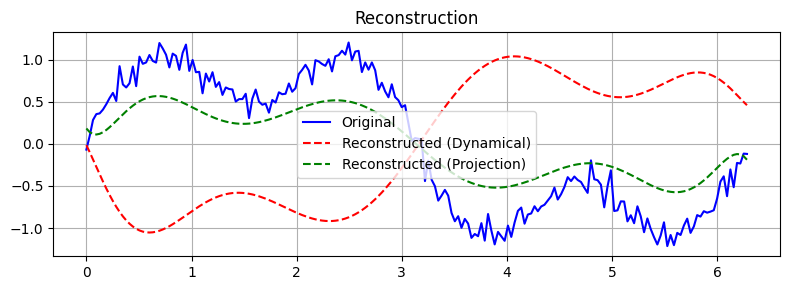

Dynamical System Coefficients:
[ 2.45511698e-04  1.10548346e+00 -2.01586427e-02 -7.61921681e-01
  1.22127289e-01  3.97929805e-01  2.18803772e-01 -8.41084939e-01
 -9.89718202e-02  3.36601961e-01]

Direct Projection Coefficients:
[-1.38858207e-03 -5.50309770e-01 -2.38486835e-03  4.08643519e-01
 -7.50694164e-03 -9.47431373e-02  8.43083750e-03  4.81731213e-01
 -2.09684209e-05 -4.30944955e-01]


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre
from scipy import linalg

class LegendreTimeSeriesRepresentation:
    """
    Class for representing time series data using Legendre polynomials,
    inspired by the Legendre Memory Unit (LMU) approach.
    """
    
    def __init__(self, degree=5, theta=None, dt=1.0):
        """
        Initialize the representation.
        
        Parameters:
            degree (int): Number of Legendre polynomials to use (0 to degree-1)
            theta (float): Time window length (in time units)
            dt (float): Time step for discretization
        """
        self.degree = degree
        self.theta = theta
        self.dt = dt
        self.A = None  # Continuous-time system matrix
        self.B = None  # Continuous-time input matrix
        self.A_d = None  # Discretized system matrix 
        self.B_d = None  # Discretized input matrix
        
        # Initialize matrices if theta is provided
        if theta is not None:
            self._initialize_matrices()
        
    def _create_system_matrices(self):
        """Create the A and B matrices for the LMU dynamical system."""
        # Initialize matrices
        A = np.zeros((self.degree, self.degree))
        B = np.zeros((self.degree, 1))
        
        # Fill matrices according to the LMU paper (equation 2)
        for i in range(self.degree):
            B[i, 0] = (2*i + 1) * (-1)**i
            for j in range(self.degree):
                if i < j:
                    A[i, j] = (2*i + 1) * (-1)
                else:
                    A[i, j] = (2*i + 1) * (-1)**(i-j+1)
        
        # Scale by theta
        A = A / self.theta
        B = B / self.theta
        
        return A, B
    
    def _discretize_system(self, A, B, dt):
        """
        Discretize continuous-time system (A, B) using zero-order hold.
        
        Parameters:
            A (ndarray): System matrix
            B (ndarray): Input matrix
            dt (float): Time step
            
        Returns:
            A_d (ndarray): Discretized system matrix
            B_d (ndarray): Discretized input matrix
        """
        n = A.shape[0]
        M = np.zeros((n+1, n+1))
        M[:n, :n] = A
        M[:n, n:] = B
        
        # Matrix exponential for ZOH discretization
        Md = linalg.expm(M * dt)
        A_d = Md[:n, :n]
        B_d = Md[:n, n:]
        
        return A_d, B_d
    
    def _initialize_matrices(self):
        """Initialize the system matrices."""
        if self.theta is None:
            raise ValueError("theta must be specified before initializing matrices")
        
        self.A, self.B = self._create_system_matrices()
        self.A_d, self.B_d = self._discretize_system(self.A, self.B, self.dt)
    
    def shifted_legendre(self, n, x):
        """
        Compute the shifted Legendre polynomial of degree n at points x.
        Shifted to the interval [0, 1] instead of [-1, 1].
        
        Parameters:
            n (int): Degree of the Legendre polynomial
            x (ndarray): Points at which to evaluate the polynomial
            
        Returns:
            ndarray: Values of the shifted Legendre polynomial
        """
        # Map x from [0, 1] to [-1, 1] for standard Legendre polynomials
        x_mapped = 2*x - 1
        # Get the standard Legendre polynomial of degree n
        P = legendre(n)
        # Evaluate the polynomial at the mapped points
        return P(x_mapped)
    
    def fit(self, time_series, theta=None):
        """
        Fit the Legendre representation to the time series.
        
        Parameters:
            time_series (ndarray): 1D array of time series data
            theta (float, optional): Time window length. If None, use time_series length.
            
        Returns:
            ndarray: Coefficients of the Legendre representation
        """
        if theta is None and self.theta is None:
            theta = len(time_series)
        
        # Update theta if provided
        if theta is not None:
            self.theta = theta
            self._initialize_matrices()
        elif self.A_d is None or self.B_d is None:
            # Ensure matrices are initialized
            self._initialize_matrices()
        
        # Run the dynamical system to get the memory state
        memory_state = self.simulate_dynamics(time_series)
        
        # Return the final state, which contains the Legendre coefficients
        return memory_state[-1]
    
    def simulate_dynamics(self, signal):
        """
        Simulate the LMU dynamics for a given input signal.
        
        Parameters:
            signal (ndarray): Input time series
            
        Returns:
            ndarray: Memory states over time (each row is a state vector)
        """
        # Check if matrices are initialized
        if self.A_d is None or self.B_d is None:
            raise ValueError("System matrices not initialized. Call fit() or _initialize_matrices() first.")
        
        # Initialize memory state
        m = np.zeros((len(signal), self.degree))
        
        # Simulate dynamics with correct matrix operations
        for t in range(1, len(signal)):
            # Correct way to update the memory state:
            # m[t] = A_d * m[t-1] + B_d * input
            # For matrix multiplication with vectors:
            m[t] = np.dot(self.A_d, m[t-1]) + (self.B_d * signal[t-1]).flatten()
        
        return m
    
    def reconstruct(self, coeffs, length):
        """
        Reconstruct a signal from its Legendre coefficients.
        
        Parameters:
            coeffs (ndarray): Legendre coefficients
            length (int): Length of the reconstructed signal
            
        Returns:
            ndarray: Reconstructed signal
        """
        t = np.linspace(0, 1, length)
        reconstructed = np.zeros(length)
        
        for i in range(len(coeffs)):
            reconstructed += coeffs[i] * self.shifted_legendre(i, t)
        
        return reconstructed
    
    def fit_multiple_segments(self, segments):
        """
        Fit the Legendre representation to multiple time series segments.
        
        Parameters:
            segments (ndarray): 2D array where each row is a time series segment
            
        Returns:
            ndarray: 2D array of coefficients, one row per segment
        """
        coeffs = []
        for segment in segments:
            coeffs.append(self.fit(segment))
        return np.array(coeffs)
    
    def project_to_legendre_basis(self, time_series):
        """
        Project a time series directly onto Legendre polynomials without
        using the dynamical system. This is an alternative to using the 
        dynamical system approach.
        
        Parameters:
            time_series (ndarray): 1D array of time series data
            
        Returns:
            ndarray: Coefficients of the Legendre representation
        """
        # Normalize time to [0, 1]
        t = np.linspace(0, 1, len(time_series))
        
        # Calculate projections
        projections = np.zeros(self.degree)
        for i in range(self.degree):
            # Calculate the inner product with each Legendre polynomial
            poly_values = self.shifted_legendre(i, t)
            # Normalization factor
            norm_factor = (2*i + 1) / 2
            projections[i] = norm_factor * np.sum(time_series * poly_values) / len(time_series)
        
        return projections

# Example usage:
if __name__ == "__main__":
    # Generate a synthetic time series
    t = np.linspace(0, 2*np.pi, 200)
    signal = np.sin(t) + 0.5*np.sin(3*t) + 0.1*np.random.randn(len(t))
    
    # Create the representation
    ltr = LegendreTimeSeriesRepresentation(degree=10, theta=len(signal), dt=1.0)
    
    # Fit the representation
    # Method 1: Using the dynamical system
    memory_states = ltr.simulate_dynamics(signal)
    final_state = memory_states[-1]
    
    # Method 2: Direct projection
    coeffs = ltr.project_to_legendre_basis(signal)
    
    # Reconstruct the signal
    reconstructed1 = ltr.reconstruct(final_state, len(signal))
    reconstructed2 = ltr.reconstruct(coeffs, len(signal))
    
    # Plot the results
    plt.figure(figsize=(8, 3))
    
    plt.plot(t, signal, 'b', label='Original')
    plt.plot(t, reconstructed1, 'r--', label='Reconstructed (Dynamical)')
    plt.plot(t, reconstructed2, 'g--', label='Reconstructed (Projection)')
    plt.legend()
    plt.grid(True)
    plt.title('Reconstruction')
  
    
    plt.tight_layout()
    plt.show()
    
    # Print the coefficients
    print("Dynamical System Coefficients:")
    print(final_state)
    print("\nDirect Projection Coefficients:")
    print(coeffs)

In [24]:
final_state.shape

reconstructed1 = ltr.reconstruct(final_state, len(signal))
final_state

array([ 2.45511698e-04,  1.10548346e+00, -2.01586427e-02, -7.61921681e-01,
        1.22127289e-01,  3.97929805e-01,  2.18803772e-01, -8.41084939e-01,
       -9.89718202e-02,  3.36601961e-01])

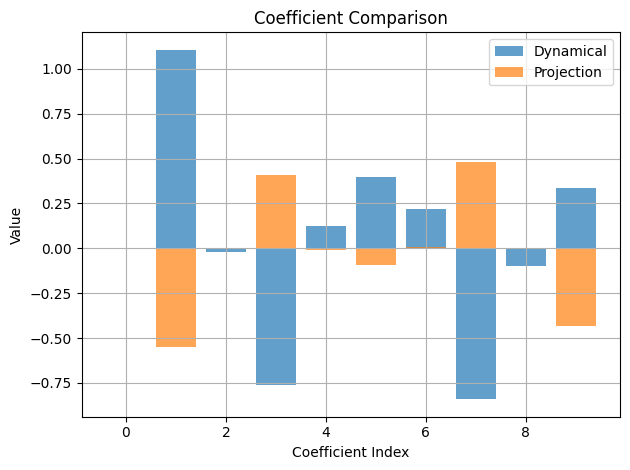

Dynamical System Coefficients:
[ 2.45511698e-04  1.10548346e+00 -2.01586427e-02 -7.61921681e-01
  1.22127289e-01  3.97929805e-01  2.18803772e-01 -8.41084939e-01
 -9.89718202e-02  3.36601961e-01]

Direct Projection Coefficients:
[-1.38858207e-03 -5.50309770e-01 -2.38486835e-03  4.08643519e-01
 -7.50694164e-03 -9.47431373e-02  8.43083750e-03  4.81731213e-01
 -2.09684209e-05 -4.30944955e-01]


In [ ]:
plt.bar(range(ltr.degree), final_state, alpha=0.7, label='Dynamical')
plt.bar(range(ltr.degree), coeffs, alpha=0.7, label='Projection')
plt.title('Coefficient Comparison')
plt.xlabel('Coefficient Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print the coefficients
print("Dynamical System Coefficients:")
print(final_state)
print("\nDirect Projection Coefficients:")
print(coeffs)